In [1]:
import numpy as np
import scipy.optimize as op
import datetime
import emcee
import matplotlib.pyplot as plt
import corner
from scipy.stats import norm, halfnorm
%matplotlib inline

In [2]:
mars = np.genfromtxt('harp_mars.dat', usecols=np.arange(0, 9))
jupiter = np.genfromtxt('harp_jupiter.dat', usecols=np.arange(0, 8))
uranus = np.genfromtxt('harp_uranus.dat', usecols=np.arange(0, 8))

In [3]:
mars_etamb = mars[:,5]
jupiter_etamb = jupiter[:,5]
uranus_etamb = uranus[:,5]

mars_dates = mars[:,0]
jupiter_dates = jupiter[:,0]
uranus_dates = uranus[:,0]

mars = mars[mars[:,1] > 5]
mars = mars[mars[:,1] < 19]
mars = mars[mars[:,5] > 0]
jupiter = jupiter[jupiter[:,1] > 5]
jupiter = jupiter[jupiter[:,1] < 19]
jupiter = jupiter[jupiter[:,5] > 0]
uranus = uranus[uranus[:,1] > 5]
uranus = uranus[uranus[:,1] < 19]
uranus = uranus[uranus[:,5] > 0]

planets_etamb = np.concatenate((mars_etamb, jupiter_etamb, uranus_etamb), axis=0)
raw_dates = np.concatenate((mars_dates, jupiter_dates, uranus_dates), axis=0)
dates = [datetime.datetime.strptime(str(int(date)),'%Y%m%d') for date in raw_dates]

In [168]:
oldest = min(dates)
days = np.array([np.float64((date - oldest).days) + 1 for date in dates])
days = days/np.max(days)

In [123]:
m_true = 0.0
b_true = .5

delty1_true = 0.0
delty2_true = 0.3
sigsq1_true = .01
sigsq2_true = .04
a1_true = .5
a2_true = .5
L_true = 1.0

In [6]:
# adapted code from http://code.activestate.com/recipes/189971-basic-linear-algebra-matrix/
def minor(matrix, i, j):
    #input should be numpy matrix
    matrix = np.asarray(matrix)
    m = np.zeros((matrix.shape[0]-1, matrix.shape[1]-1))
    m = np.matrix(m)
    # loop through the matrix, skipping over the row and column specified by i and j
    minor_row = minor_col = 0
    for row in range(matrix.shape[0]):
        if not row == i: # skip row i
            for col in range(matrix.shape[1]):
                if not col == j: # skip column j
                    m[(minor_row, minor_col)] = matrix[(row, col)]
                    minor_col += 1
            minor_col = 0
            minor_row += 1
    return m

In [144]:
def lnlike(theta, x, y):
    m, b, delty1, delty2, sigsq1, sigsq2, a1, a2, L = theta
#     a2 = 1.0 - a1
    BN_lim = 200
    #number in variable name is the gaussian j
    m = 0
#     delty1_true = 0.0
#     delty2_true = 0.3
#     sigsq1_true = .01
#     sigsq2_true = .04
    y_mod1 = m*x + b - delty1
    y_mod2 = m*x + b - delty2
    chisq1 = (1/sigsq1) * np.matmul(y-y_mod1, (y-y_mod1).T)
#     print(chisq1)
#     print(delty1/sigsq1)
    chisq2 = (1/sigsq2) * np.matmul(y-y_mod2, (y-y_mod2).T)
    if chisq1 > BN_lim:
        chisq1 = BN_lim
    if chisq2 > BN_lim:
        chisq2 = BN_lim
    H = [np.exp(-chisq1/2), np.exp(-chisq2/2)]
#     print(H)
    beta1 = -2.0*np.log(a1/np.sqrt(2*np.pi*sigsq1))
    beta2 = -2.0*np.log(a2/np.sqrt(2*np.pi*sigsq2))
    M = []
    for i in range(len(days)):
        if i == 0:
            temp_y = y[i+1:]
            temp_x = x[i+1:]
        else:
            temp_y = np.concatenate((y[:i],y[i+1:]))
            temp_x = np.concatenate((x[:i],x[i+1:]))
        temp_y_mod1 = m*temp_x + b - delty1
        temp_y_mod2 = m*temp_x + b - delty2
        minor_chisq1 = sigsq1 * np.matmul(temp_y-temp_y_mod1, (temp_y-temp_y_mod1).T)
        minor_chisq2 = sigsq2 * np.matmul(temp_y-temp_y_mod2, (temp_y-temp_y_mod2).T)
        M.append([np.exp(-.5*(beta1 - minor_chisq1)), np.exp(-.5*(beta2 - minor_chisq2))])
    
    MxH = np.matmul(np.matrix(M), np.matrix(H).T)
    
    #calc optimal lambda
    full_a = np.array([[a1, a2],]*len(x))
    full_H = np.array([H,]*len(x))
    N = np.multiply(np.divide(M,full_a),full_H)
    NxH = np.matmul(np.matrix(N), np.matrix(H).T)
    lambda_star = -0.5*np.sum(np.divide(NxH,MxH))
    print(lambda_star)
#     if np.any(MxH)<= 0:
#         print(MxH)
#         exit()
    return np.log(MxH).sum() + L*(a1+a2-1)

In [110]:
lnlike((0.00, .6, 0.0, 0.3, .01, .04, .5, .5, 1.0), days, planets_etamb)

-2.04976186279e-41


-54302.439829837109

In [34]:
print(np.exp(-200))
print(np.finfo(np.float64).eps)

1.38389652674e-87
2.22044604925e-16


In [22]:
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_true, b_true, delty1_true, delty2_true, sigsq1_true, sigsq2_true, a1_true, a2_true, L_true], args=(days, planets_etamb))
m_ml, b_ml, delty1_ml, delty2_ml, sigsq1_ml, sigsq2_ml, a1_ml, a2_ml, L_ml = result["x"]

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in exp
/Users/rebeccachen/anaconda/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp
/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in sqrt
/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in exp
/Users/rebeccachen/anaconda/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


In [23]:
print(m_ml, b_ml, delty1_ml, delty2_ml, sigsq1_ml, sigsq2_ml, a1_ml)

0.0 0.5 0.0 0.3 0.01 0.04 0.5


In [155]:
def lnprior(theta):
    m, b, delty1, delty2, sigsq1, sigsq2, a1, a2, L = theta
    if 0.0 < b < 1.0 and 0.0 < a1 < 1.0 and 0.0 < a2 < 1.0 and sigsq1 > 0.0 and sigsq2 > 0.0 and L > 0.0:
#         pri_m = norm.logpdf(m, 0.0, .01)
        pri_delty1 = norm.logpdf(delty1, 0.0, 0.5)
        pri_delty2 = norm.logpdf(delty2, 0.3, 0.5)
        pri_sigsq1 = norm.logpdf(sigsq1, .01, .01)
        pri_sigsq2 = norm.logpdf(sigsq2, .04, .01)
        pri_a1 = norm.logpdf(a1, 0.5, .5/3.0)
        pri_a2 = norm.logpdf(a2, 0.5, .5/3.0)
        pri_L = norm.logpdf(L, -2.04976186279e-41, 10**-5)
        return pri_delty1 + pri_delty2 + pri_sigsq1 + pri_sigsq2 + pri_a1 + pri_a2 + pri_L
    return -np.inf

In [156]:
def lnprob(theta, x, y):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y)

In [157]:
ndim, nwalkers = 9, 200
# pos = [result["x"] + np.random.randn(ndim)*1e-4*[.2, .1, .5, .3, .3] for i in range(nwalkers)] #nwalkers x ndim entries
pos = [np.random.randn(ndim)*1e-4*[0.00001, .6, 0.0, 0.3, .01, .04, .5, .5, 1.0] for i in range(nwalkers)]

In [158]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(days, planets_etamb), threads=4, a=2.0)

-3.61964494558e-37
-5.2475453163e-37
-1.03631764245e-37
-8.24761684978e-37
-4.51460892863e-38
-9.01344832485e-37
-5.98166391856e-37
-7.24542503666e-37
-4.63744732858e-37
-6.04689545212e-37
-3.80096966258e-37
-5.26561874206e-38
-2.76443202754e-37
-6.804106509e-37
-2.95286829184e-38
-3.53011812995e-37
-3.16917907836e-37
-1.77534913483e-37
-5.2856852748e-37
-2.11090111615e-36
-1.3990373415e-37
-3.519840991e-37
-5.16426249655e-38
-3.98677844389e-37
-1.90751360978e-37
-1.93298040733e-37
-3.67992497188e-37
-2.0581726612e-37
-1.40441447756e-37
-2.82707338301e-37
-5.31690118113e-38
-1.14809614297e-37
-1.98902767882e-37
-1.65130771746e-37
-3.99848793046e-37
-6.30684897102e-38
-1.21633637322e-37
-1.01189248922e-37
-2.44555190407e-37
-1.02698841508e-37
-2.18622398545e-37
-3.40074761764e-38
-8.5082271872e-38
-4.957456782e-37
-5.11968533956e-37
-9.1210063656e-37
-4.75828912487e-37
-8.93258326417e-37
-3.35464593448e-38
-1.48397338279e-37
-2.0397270908e-37
-9.94815612335e-37
-1.59377863439e-37
-3.645

-9.67721554281e-38
-1.19184012128e-37
-2.08879139501e-37
-1.36516552889e-37
-1.80969212367e-37
-1.5119548849e-37
-2.10759825306e-38
-3.24760045664e-38
-3.04331432812e-38
-4.673695169e-38
-1.2323044369e-38
-1.45367092473e-37
-8.49100301281e-38
-2.42913589804e-37
-3.51553232772e-38
-2.930328838e-38
-8.63057601874e-38
-8.64430754498e-38
-4.68742384157e-37
-9.06231316775e-39
-7.04172846166e-38
-2.00523536629e-38
-4.33829089865e-37
-3.54087302066e-38
-1.34284555545e-37
-8.95858376832e-38
-1.48604552103e-37
-9.23244156731e-39
-3.84180761023e-38
-1.35224882965e-37
-1.84247488045e-37
-8.90865097471e-38
-1.79136848574e-37
-1.15412151594e-37
-4.36746724929e-37
-1.83222542158e-37
-2.94945112203e-38
-2.46448878573e-38
-2.46586508262e-38
-4.29698923054e-38
-1.05581124336e-38
-6.40432672587e-37
-5.26791707201e-38
-1.64958600463e-37
-1.79716370437e-38
-1.47268743365e-37
-7.10268331258e-38
-3.9920158218e-38
-2.82924261407e-37
-4.03198299378e-38
-5.66296377742e-38
-1.41734431413e-37
-3.5266720395e-38
-

-7.94849331735e-39
-1.9472439216e-37
-6.36832020047e-38
-1.07123902547e-38
-2.39665184229e-37
-4.80227300389e-38
-4.40995263426e-38
-5.72861122784e-38
-2.46991041662e-38
-4.51811930508e-38
-3.15458718963e-38
-3.23808074518e-38
-1.83040602405e-38
-1.10962597971e-37
-3.70041900275e-38
-2.26547511045e-38
-2.13201704079e-37
-3.11111508792e-38
-1.63000648081e-38
-1.33023550019e-39
-4.35129774509e-38
-4.23679730892e-38
-3.9868525878e-37
-3.58587982691e-37
-1.40276739495e-37
-1.8882915383e-37
-1.09647261716e-37
-7.78854037012e-38
-2.34179293594e-38
-1.25485468857e-37
-6.42083440736e-38
-7.5004290135e-38
-1.31324094715e-37
-1.41140314026e-37
-2.98949709213e-39
-2.34970958488e-38
-1.90993031186e-38
-2.00636568778e-37
-9.7737276084e-38
-3.72894831672e-38
-2.98478377757e-38
-6.40731201619e-38
-1.60342524697e-38
-1.55783363169e-37
-1.61084433006e-37
-5.56828481603e-38
-2.6095751098e-37
-4.38865410468e-39
-5.71949341247e-38
-2.75964497283e-39
-3.9660749861e-38
-9.35009784743e-38
-1.12044372995e-37


-4.80512236812e-38
-9.63282594208e-38
-3.53071083661e-38
-1.98407638533e-38
-7.93919172111e-38
-1.25700753337e-38
-3.9040566488e-38
-9.81853038995e-38
-4.17662937729e-38
-1.1639786366e-38
-3.3414890991e-37
-9.35358953249e-39
-2.35831196957e-38
-1.08102726386e-37
-2.45206582715e-38
-5.4482051123e-38
-4.37697307252e-38
-4.96748867783e-40
-1.73894401554e-38
-6.89367900799e-39
-1.2286694189e-38
-8.7637814231e-38
-2.60711625356e-38
-2.23576834016e-38
-9.63150937062e-38
-1.21391780926e-38
-1.40865732935e-38
-4.8595062008e-39
-5.79290856615e-38
-9.94175740832e-39
-7.19933576185e-39
-3.05841977492e-38
-2.05889156992e-39
-1.93232888265e-38
-6.15432155416e-38
-8.16409666671e-38
-3.45501394024e-39
-1.16586817122e-38
-1.30461300556e-39
-4.44998627615e-38
-5.65557893522e-38
-3.56832075838e-39
-1.10781074921e-38
-9.885288402e-38
-1.42779095678e-38
-1.4925966175e-37
-1.35339691126e-38
-5.13465731253e-38
-2.32029250077e-39
-2.11834936971e-39
-3.28376846632e-38
-8.18282272996e-38
-1.27119872585e-38
-5.

-6.7093279493e-37
-1.40224521369e-39
-1.86050111094e-37
-2.83946665842e-38
-6.77094569227e-39
-1.13275775097e-38
-1.02855069592e-38
-1.10315722936e-38
-3.90971843338e-38
-3.01485126333e-38
-3.51241017212e-37
-1.58647329561e-38
-5.72103437586e-39
-4.5612770458e-39
-2.34382609989e-38
-1.18521129867e-38
-1.28230631443e-38
-1.312318418e-38
-4.25440976341e-38
-2.21020641024e-39
-3.88022904753e-38
-4.42201409143e-38
-1.33215109478e-38
-5.05854394583e-38
-1.73795359885e-38
-9.43732472095e-38
-2.83713476625e-38
-1.20176620068e-38
-1.90453815276e-40
-7.41674119621e-39
-2.81749130786e-38
-4.34820363962e-38
-1.16337465221e-38
-7.43675368454e-39
-1.01888701292e-38
-3.04868123679e-39
-1.82719594381e-38
-1.72579806806e-37
-8.21804168335e-39
-4.28409016022e-38
-1.80672483842e-38
-9.41112416139e-38
-6.61457888744e-38
-5.84898143011e-38
-1.52633577876e-39
-1.4505870842e-39
-3.54255705092e-39
-1.85338419341e-38
-2.69314896754e-39
-1.08885499073e-39
-1.46171772912e-39
-8.05109255055e-38
-3.82593077224e-4

-2.44062469764e-38
-2.00062972473e-38
-4.16394500112e-38
-6.10865052111e-39
-7.23180057591e-40
-3.09365089626e-38
-8.74754160945e-40
-1.32815888029e-39
-3.5405702253e-39
-7.83352708068e-39
-2.07449470372e-38
-4.36425747553e-38
-5.83043777854e-38
-5.32845049248e-40
-4.66297071318e-38
-3.60821135475e-39
-1.6134408568e-39
-9.94888688208e-39
-7.51065533043e-40
-2.54376153312e-39
-8.77164120793e-38
-2.17940989313e-38
-2.47407317692e-40
-2.37927898507e-39
-1.34991850499e-39
-1.81873795675e-38
-2.5443586276e-39
-4.85738760366e-38
-2.26973052759e-38
-6.65592349299e-39
-6.56993879592e-39
-4.52488927612e-38
-7.01622594847e-38
-7.6679668448e-38
-4.53234681268e-39
-6.73281105148e-40
-3.91604366635e-38
-9.52513215698e-39
-9.86855445755e-40
-3.14310770048e-38
-7.99069783262e-40
-1.06119930422e-38
-5.94437677406e-38
-3.77083844796e-39
-5.91434098082e-39
-6.08512220657e-39
-3.1966608817e-39
-1.44753764928e-38
-4.27572027653e-39
-2.62340418043e-38
-4.18226749934e-39
-6.35527194643e-38
-1.03340207978e-3

-2.84613527637e-40
-2.2828451963e-39
-2.76026817343e-40
-4.55810501468e-40
-9.28990254603e-39
-1.74775690125e-38
-2.10868852043e-39
-5.09984389413e-39
-2.09887901535e-38
-2.38800965142e-39
-7.63227062006e-40
-7.88073121374e-40
-2.86394041496e-39
-2.30708861826e-39
-2.95883928051e-39
-1.04363217786e-39
-3.27306513695e-40
-4.15072997893e-39
-2.34595368111e-38
-1.69032731871e-37
-7.14427669922e-38
-3.9874902224e-40
-3.39265362508e-39
-4.70151377103e-38
-4.89240549403e-40
-7.46861645384e-39
-5.86871882794e-38
-1.56584954075e-38
-2.17311376134e-39
-3.28989921475e-39
-1.64986187625e-39
-1.10307781275e-39
-7.81611618665e-40
-3.87357510109e-39
-8.17736529616e-40
-1.35341730061e-40
-2.84549868297e-39
-2.22560671899e-38
-8.5876281459e-39
-1.34536934922e-38
-3.14880305846e-39
-8.95374223648e-39
-2.40560859576e-39
-8.837076479e-40
-4.44910940922e-39
-1.48495874049e-38
-7.72989850407e-40
-3.48320142017e-39
-4.13462638029e-38
-1.69600790813e-38
-2.84641246246e-39
-9.44304603991e-39
-5.41159591474e-3

-1.85550811896e-39
-1.496242826e-38
-1.86073691688e-39
-4.30851777037e-39
-3.5266832145e-39
-5.09906162656e-41
-1.78450829558e-39
-6.24086436845e-39
-4.5988741327e-40
-2.68264070879e-40
-2.724438222e-39
-7.95510875649e-38
-3.67756354544e-38
-1.6898377927e-39
-9.36178048908e-40
-1.29150633422e-40
-3.9228087287e-40
-4.39119054434e-40
-1.40143039694e-38
-2.4076543347e-39
-2.77968387086e-39
-2.99080850294e-38
-2.99713333952e-39
-5.18262518395e-39
-1.12362482386e-37
-8.76121915728e-40
-8.36692714628e-38
-4.60331212657e-38
-2.47856257495e-40
-2.81219574168e-39
-3.38688896282e-39
-2.84731943213e-39
-1.90020274923e-39
-1.88574554433e-39
-6.22958945698e-40
-3.97405438141e-39
-1.58227346932e-39
-1.48565037213e-39
-5.49475786812e-40
-3.31176443214e-40
-9.13690832928e-39
-3.29415129958e-39
-1.465278605e-38
-2.67220035628e-38
-7.26323451741e-41
-3.99688931382e-39
-2.06935865039e-38
-1.34441017166e-38
-5.70436887952e-40
-9.91261165153e-39
-2.56759922122e-40
-8.50627708106e-39
-2.92690018856e-40
-4.0

-4.0311197054e-40
-6.76400183413e-39
-3.43450165653e-40
-4.32353821157e-39
-5.50180939279e-39
-2.96244282309e-40
-1.61000341945e-39
-8.37061871172e-40
-1.76146401403e-39
-1.5889151114e-40
-2.33971191828e-40
-1.74153160536e-39
-3.62192838015e-40
-1.14885343816e-39
-3.77223216244e-39
-7.38294310878e-40
-2.23070199881e-40
-2.75746368933e-39
-6.14649664826e-40
-6.05687031163e-40
-2.03069477261e-39
-1.69017628653e-38
-6.12335070611e-39
-1.05677437297e-40
-1.25639604969e-40
-1.01140316525e-39
-7.1983515176e-40
-5.90253952195e-40
-3.98289092643e-40
-1.68026759218e-39
-1.18918664413e-39
-1.33004895049e-39
-2.98296341737e-41
-6.72681983754e-40
-3.17769385238e-39
-4.76597544699e-40
-1.03809811336e-38
-1.36030062253e-39
-3.09956516953e-39
-2.05169285437e-39
-5.30494169558e-39
-1.67587310658e-39
-1.3112528366e-40
-1.33724256266e-40
-1.22616809835e-40
-1.84518638212e-39
-1.15383771548e-40
-4.63222027441e-40
-1.13665292363e-40
-3.48753154088e-38
-1.34864780079e-40
-1.10171254902e-39
-3.39786924447e-

-2.40859104989e-39
-1.18340783707e-39
-4.02692306444e-40
-4.46811871827e-40
-4.73080700339e-40
-4.18716889093e-40
-1.26162503038e-41
-3.02050833936e-39
-3.51911970341e-40
-5.81951518194e-40
-8.05638352001e-39
-8.2304554628e-40
-1.54526675579e-39
-6.98247245445e-40
-5.00784419649e-40
-2.97592424563e-40
-3.36890092502e-40
-1.28162423293e-39
-4.75773706529e-38
-7.66095887299e-41
-1.97504495085e-39
-9.80863743057e-41
-5.72097742244e-40
-8.7662016161e-40
-3.99462568956e-40
-1.42060093754e-40
-7.86870858586e-41
-1.27082289253e-40
-5.81760818741e-41
-9.01358387537e-40
-7.78671869272e-40
-3.69396607145e-40
-1.63753529806e-40
-5.76798670547e-40
-4.2214029465e-40
-1.12147059813e-39
-1.84830443772e-40
-1.29753361506e-39
-2.76649668735e-40
-3.61912851206e-40
-3.35258255757e-41
-5.37409399242e-40
-1.33213105353e-39
-1.53239263706e-39
-5.40104451603e-40
-2.23035095596e-40
-3.91875700605e-40
-8.14314009845e-38
-5.81825133703e-40
-1.78120960617e-39
-4.00979729285e-39
-1.13626837526e-40
-3.25278672115e

-5.1304112223e-39
-7.17889041829e-41
-1.90500442376e-41
-3.40095123808e-40
-1.57512280004e-40
-3.47284211006e-40
-8.69748049379e-40
-6.33914426956e-41
-8.33587355596e-40
-4.1447503203e-40
-3.41351701295e-41
-1.14100274677e-39
-3.70401964032e-39
-2.2293127622e-39
-4.4686651252e-40
-3.04336295308e-41
-1.29711714142e-41
-5.13366237491e-41
-3.5176427013e-41
-2.83520243712e-40
-7.88068148038e-41
-7.40834375657e-40
-1.12943615132e-38
-4.3111500728e-41
-1.46712335287e-39
-2.22015915517e-39
-4.57220330109e-41
-6.65703072367e-40
-3.88699879634e-40
-2.11588579423e-40
-4.88313918011e-40
-2.52198256593e-40
-5.33898166102e-41
-2.69289586089e-39
-2.44859106397e-41
-7.74321508115e-40
-4.05108597186e-41
-9.18948705575e-38
-1.32721859198e-40
-6.33771761938e-41
-6.29616095297e-40
-5.27044993114e-40
-1.50836732038e-40
-2.82327793675e-40
-7.02803721783e-40
-6.95386076123e-40
-4.54752482295e-40
-3.27169618611e-39
-3.46863370131e-38
-4.31371685718e-40
-2.50962270326e-40
-1.56020605479e-40
-6.97326699637e-40

-1.02875366455e-40
-4.41274775428e-40
-6.37916002731e-41
-2.05987031307e-41
-3.30965277561e-40
-1.82548776782e-40
-2.56905011326e-41
-7.15908671487e-41
-3.10198786155e-40
-8.47094676703e-41
-5.15751538076e-41
-1.56005202352e-40
-9.72711444911e-41
-1.15795243693e-41
-2.17388643243e-38
-7.61039657777e-41
-5.66668060412e-40
-1.64189451386e-40
-2.20354831444e-41
-1.37242813735e-40
-8.12993506051e-41
-8.58070721363e-41
-4.16143850392e-40
-2.32081186587e-40
-2.96788397517e-40
-1.68563343849e-40
-1.71664472234e-39
-1.34307951587e-40
-2.04233443959e-40
-8.77126162142e-40
-4.8739503277e-40
-1.08756458386e-40
-2.29601694894e-41
-2.19861693758e-41
-4.09812016542e-40
-2.08199736679e-41
-1.38054403517e-41
-9.92100361829e-41
-7.25016353696e-41
-7.48866555259e-40
-1.44305734915e-41
-2.96845455514e-39
-4.40544830834e-41
-4.96618961479e-41
-6.36161956157e-41
-9.54873156122e-40
-1.12472875851e-40
-6.54250942056e-41
-3.92033129317e-41
-3.14687312698e-41
-8.92391778194e-41
-1.68957604225e-41
-2.1495583833

-6.55993520692e-41
-6.89546235362e-40
-8.08941957571e-41
-5.6408352657e-41
-9.65033163913e-41
-4.65337127563e-40
-7.03681122344e-41
-5.53852210112e-41
-1.5821290299e-41
-7.65187170654e-41
-1.16838776912e-41
-7.20985630378e-41
-3.47523759635e-40
-1.39643636097e-39
-1.58388078743e-40
-2.54493235743e-41
-2.88308931749e-41
-8.8309523703e-41
-8.53719616305e-41
-7.0386141713e-41
-4.30329469892e-40
-1.9523624772e-40
-7.12597805281e-41
-1.32523246012e-40
-1.53017566592e-40
-2.31418425853e-41
-3.75770104453e-41
-3.2472961622e-41
-3.49394665106e-41
-1.79286971839e-41
-1.68977899943e-40
-9.81148144624e-41
-3.52907741435e-41
-8.37487477488e-41
-1.00055842526e-40
-5.30912097751e-40
-2.98338307649e-41
-1.88449721449e-40
-2.16786222287e-41
-4.91009414254e-41
-2.42829730303e-41
-1.5916529409e-40
-2.12281044955e-41
-2.18942263116e-40
-2.11264907031e-41
-4.44267117864e-40
-7.99587589408e-41
-1.40393865775e-41
-1.19247590982e-40
-1.89911874947e-41
-2.34149467764e-41
-1.06894618434e-40
-2.86988000977e-41


-1.81926112264e-41
-5.99382053451e-41
-1.31642664925e-41
-1.19999925882e-40
-6.29217222752e-41
-2.28279724249e-41
-1.59504184068e-41
-4.43839169684e-41
-1.69280566285e-41
-4.13236046923e-41
-2.88267210457e-41
-2.71077522162e-41
-2.54540753849e-41
-9.09321890153e-41
-1.56429035748e-41
-5.61366307264e-40
-4.43984189076e-41
-4.4615598256e-41
-2.6123686384e-41
-3.79589998558e-41
-2.30052277139e-41
-1.81262303583e-40
-3.54860830567e-41
-1.33191643161e-40
-7.91850491331e-41
-2.33365268749e-41
-2.26132183376e-41
-3.2687956448e-41
-3.15831539846e-41
-1.60234653969e-40
-1.15059869092e-40
-2.15774263114e-40
-6.04325060172e-41
-7.78738138009e-41
-1.4663421347e-40
-2.09904009855e-41
-3.13466979723e-40
-2.04691563629e-40
-1.63229479343e-41
-8.64643299034e-41
-4.53029165546e-41
-1.37028554965e-41
-1.37385295466e-41
-4.61842210006e-41
-1.94656498906e-23
-1.13953722074e-41
-4.14332906032e-41
-2.17942617288e-41
-3.28449394222e-41
-2.72027298208e-41
-3.82448549121e-41
-5.65877784679e-41
-2.90586693994e-

-2.28242678189e-41
-1.12820991514e-41
-2.60610011691e-41
-1.15837439518e-40
-5.92843265815e-41
-3.84830899782e-41
-2.27141561841e-41
-1.27576510782e-41
-1.81058924973e-41
-4.59516573186e-41
-3.97311177133e-41
-1.28293889828e-41
-3.95238057331e-41
-2.44843877848e-41
-5.83130663751e-41
-1.9123280533e-40
-1.62828745931e-40
-8.41191587719e-41
-1.34459532476e-41
-4.1130669915e-41
-9.29833779123e-41
-2.35441248778e-41
-8.78962533041e-41
-1.38069385759e-41
-1.69021327086e-41
-3.95278485592e-41
-2.80835269471e-41
-2.31560387912e-41
-2.16355160411e-41
-5.07189633356e-41


/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in exp


-1.78575492325e-41
-1.18996202731e-41
-4.35527591791e-41


/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


-2.13435056003e-41
nan
-2.05093219454e-41
-6.33896535444e-41
-1.81031402795e-41
-3.14087329955e-41
-2.12097515333e-41
-6.36039163917e-41
-1.61251696794e-41
-2.31058137579e-41
-1.48149468438e-41
-2.61978966817e-41
-2.04796562819e-41
-3.15183198794e-41
-7.53788602213e-41
-5.75441602948e-41
-1.24641606077e-41
-1.06810346233e-40
-1.67204718171e-41
-2.85495617346e-41
-2.51033962671e-41
-5.59117615137e-39
-1.02810159258e-41
-1.18484123405e-41
-1.21463964667e-41
-5.93559999867e-41
-3.88598237938e-41
-4.80523769138e-41
-3.29255262955e-41
-4.66240161793e-41
-5.3247432528e-41
-3.12355163683e-41
-2.47476889463e-41
-3.36780449144e-41
-4.4727439887e-41
-2.6473179071e-41
-8.13058613377e-41
-1.99644007334e-41
-8.2232096414e-41
-7.38902635542e-41
-4.099669442e-41
-1.43619910235e-41
-7.46832360043e-41
-4.43485909382e-41
-1.21570368272e-41
-2.2572652245e-41
-3.46256360787e-41
-1.91749670189e-41
-4.16761014559e-41
-1.04574484904e-40
-1.11764157455e-40
-1.36838218384e-41
-3.81894725921e-41
-7.95145937632e

-2.19335047663e-41
-5.17461874124e-41
-1.14333606326e-41
-6.67436761024e-41
-5.29661933103e-41
-3.62149822965e-41
-1.29554185762e-41
-1.72327903187e-41
-1.80890008341e-41
-1.30277355867e-41
-1.29778420774e-41
-4.16257572957e-41
-1.09718969416e-41
-1.67917871034e-41
-4.94013294176e-41
-4.17960083681e-41
-1.26582532254e-41
-5.03067636074e-17
-5.47847020756e-41
-2.02378986496e-41
-4.87478749723e-41
-1.80421839182e-41
-2.01858718988e-41
-1.75252149254e-41
-1.62983279332e-41
-2.821423551e-41
-2.02408924526e-41
-4.75397739126e-41
-1.44387944994e-41
-3.1673247741e-41
-2.23085823428e-41
-1.22765529544e-41
-1.11636175931e-41
-1.2364340895e-41
-1.98622874571e-41
-2.2398834209e-41
-1.07379915178e-41
-5.29725079742e-41
-3.54200314514e-41
-2.22773872443e-41
-2.30048772245e-41
-1.16373018803e-41
-1.58814458945e-41
-1.38765453779e-41
-1.71778495623e-41
-1.77816749193e-41
-9.57824935159e-41
-1.37690077158e-41
-3.80180621013e-41
-1.14624421569e-41
-3.74672125457e-41
-1.67167966135e-41
-2.0453796122e-41

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in exp


-2.57777524007e-41
-2.40293719857e-41
-1.31268585147e-41


/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


nan
-1.10506666136e-41
-1.21952049514e-41
-1.06407491584e-41
-1.81385356079e-41
-3.09344301584e-41
-8.6778366462e-41
-1.30531686273e-41
-2.32769549377e-41
-1.88756759893e-41
-4.15454862765e-41
-6.42828152827e-41
-3.38359793584e-41
-2.77034206054e-41
-1.32868693604e-41
-2.11112346784e-40
-3.57806889517e-41
-4.14696550421e-41
-1.46798555929e-41
-1.55321353796e-41
-3.3702021587e-41
-4.59892877918e-41
-2.2813174707e-41
-3.82165110559e-41
-4.07808200385e-41
-2.4671170423e-41
-1.29315860043e-40
-3.5251209259e-41
-3.62804757443e-41
-1.81993845126e-41
-2.08401810981e-41
-2.17538560304e-41
-8.18711693179e-41
-2.19051963845e-41
-5.26676795639e-41
-3.50779301412e-41
-1.8898627716e-41
-1.28285378139e-41
-3.41608135537e-41
-9.06035238805e-41
-1.69701966084e-41
-1.40850394312e-41
-1.65473289835e-41
-1.34265937823e-41
-1.41191166638e-41
-3.63795228029e-41
-1.09112570162e-41
-1.19131014064e-41
-2.05140987407e-41
-1.55109383419e-41
-2.18566773517e-41
-1.0996847603e-40
-7.90725550705e-41
-2.01088119317e

-1.57576466527e-41
-1.68616617987e-41
-1.31299096027e-41
-1.47541381651e-41
-1.75782759038e-40
-1.26702882172e-41
-1.06873007289e-41
-1.699713938e-41
-1.07521249846e-41
-2.19583902495e-41
-1.61436768939e-41
-1.41215755067e-41
-1.57025565328e-41
-6.82223076968e-41
-1.39674513657e-41
-2.53698980528e-41
-2.64867680626e-41
-3.17832293499e-41
-2.3882493063e-41
-3.58647445072e-41
-1.76705283264e-41
-1.31147375435e-41
-1.54446909689e-41
-1.08660026495e-41
-3.97355756405e-41
-1.85915525985e-41
-1.94525055893e-41
-1.10901847184e-41
-2.46828064295e-41
-1.13443006623e-41
-1.60683549824e-41
-1.04455366025e-41
-1.14410098608e-41
-1.50281860332e-41
-1.93545395685e-41
-1.12622849802e-41
-1.94396594769e-41
-4.08477976327e-41
-2.52327813126e-41
-1.35395998353e-41
-2.23785185614e-41
-1.59298995803e-41
-1.1389245027e-41
-1.29412016144e-41
-1.85386207566e-41
-1.22995379802e-41
-3.65330769935e-41
-1.19508161734e-41
-2.02455801919e-41
-2.25713852924e-41
-4.79983201794e-41
-1.60315364814e-41
-2.37594205225e-

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in exp


-2.3934047919e-41


/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


nan
-1.55000630041e-41
-3.02380384658e-41
-1.67836759021e-41
-2.19898001642e-41
-1.83036750499e-41
-1.07800893617e-41
-1.41965238535e-41
-2.56285359467e-41
-3.50428176615e-41
-1.05519800383e-41
-2.02402905435e-41
-1.85328137709e-41
-2.30074280613e-41
-1.03299683151e-41
-3.26317898175e-41
-3.35206625384e-41
-1.44692160256e-41
-2.08215483768e-41
-3.4645640202e-41
-2.573690188e-41
-9.8840288698e-39
-2.36019739497e-41
-1.43543397243e-41
-1.39728039638e-41
-2.35037642011e-41
-1.45771771729e-41
-1.04330067994e-41
-2.73807084002e-41
-1.03021562959e-41
-1.20564346155e-41
-2.52038120143e-41
-2.10048259562e-41
-1.24540672636e-41
-1.48376776703e-41
-2.28381124328e-41
-2.1287966893e-41
-1.13871628342e-41
-2.86853513306e-41
-2.90108328116e-41
-1.33534897487e-41
-2.10374442309e-41
-3.76355914455e-41
-7.03196819601e-41
-2.29666528911e-41
-3.5599104664e-41
-2.28895032166e-41
-1.42921275847e-41
-1.20294197666e-41
-1.45906204671e-40
-1.3622626184e-41
-2.23984097398e-41
-1.76812995864e-41
-1.12361896366e

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in exp


-2.63989647986e-41
-1.40320057943e-41


/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


nan
-1.86671433476e-41
-1.15001984644e-41
-1.15348326683e-41
-1.59608509326e-41
-1.10028283493e-41
-1.1618174724e-41
-1.68513310041e-41
-1.24172551033e-41
-1.59785425712e-41
-1.07664110341e-41
-1.23659942247e-41
-1.35413730738e-41
-2.67239101717e-41
-1.51071329251e-41
-3.07775334687e-41
-2.50958632625e-41
-1.3794613223e-41
-2.31389618787e-41
-1.46439993819e-41
-1.91614577353e-41
-2.28558682914e-41
-1.99610267791e-41
-1.49527224495e-41
-1.72894356495e-41
-3.28860725147e-41
-1.32163441829e-41
-3.28559173022e-41
-1.74869735657e-41
-1.11924596169e-41
-2.32784383803e-41
-1.16047262868e-41
-1.8268886638e-41
-2.78951028059e-41
-1.13926958852e-41
-1.19224125491e-41
-1.29312399908e-41
-1.1556524747e-41
-1.09490730988e-41
-1.66534748175e-41
-1.27700485969e-41
-2.54521991185e-41
-1.66042672503e-41
-1.0913207976e-41
-1.31512472686e-41
-2.34571734809e-41
-1.57448914345e-41
-2.53432062506e-41
-1.5669710307e-41
-2.5937570338e-41
-1.38848822629e-41
-1.50500562728e-41
-2.22900788346e-41
-1.35977078217e

-1.45473267095e-41
-1.48537145372e-41
-1.90666323365e-41
-1.30940920966e-41
-2.3835758275e-41
-1.27507887508e-41
-1.23532485102e-41
-4.12467450971e-41
-1.08575405611e-41
-1.63484264924e-41
-1.16265381693e-41
-1.06919626162e-41
-1.61543865775e-41
-2.21496235747e-41
-1.1157700947e-41
-1.73427443014e-41
-1.85928779417e-41
-1.81750381919e-41
-2.2434576399e-41
-1.91152697867e-41
-2.17325751965e-41
-1.18709854275e-41
-1.22960575111e-41
-1.13209816648e-41
-2.16008771436e-41
-1.1864645997e-41
-1.71797649467e-41
-1.7035825668e-41
-1.35464981577e-41
-1.69129678625e-41
-1.46879882259e-41
-1.20568339998e-41
nan
-1.30700269683e-41
-1.59326363679e-41
-1.24727704933e-41
-2.07867658099e-41
-1.34762034361e-41
-1.02882527637e-41
-6.20283942009e-18
-4.16238604402e-41
nan
-2.04739700725e-41
-1.82472208042e-41
-1.03016213483e-41
-7.7093495149e-27
-1.52019753176e-41
-1.27682666788e-41
-1.31902806635e-41
-1.85604638757e-41
-1.50272947645e-41
-1.08643399375e-41
-1.25036439563e-41
-1.98395151405e-41
-2.0167153

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: overflow encountered in true_divide


nan
-1.20691155255e-41
-1.33084887029e-41
-1.69806834739e-41
-1.80331135163e-41
-1.55813070286e-41
-1.55590579626e-41
-1.65087894378e-41
-1.44526584282e-41
-1.60245457584e-41
-1.87078517826e-41
-1.28189583518e-41
-1.38000013019e-41
-1.47279968857e-41
-2.06796998897e-41
-2.5875715407e-41
-1.17619204572e-41
-1.12426129993e-41
-2.06573759894e-41
-1.93506203314e-41
-1.79433702721e-41
-1.56229540775e-41
-1.24648962577e-41
-1.05274748616e-41
-1.72772522574e-41
-1.58701939697e-41
-1.82704741572e-41
-1.54441071994e-41
-1.73589565338e-41
-1.23679027663e-41
-2.28089385491e-41
-1.28669201685e-41
-1.88160238332e-41
-1.58382787109e-41
-1.39952397336e-41
-1.23160012937e-41
-1.43879227091e-41
-1.75450359559e-41
nan
-1.18842378509e-41
-1.54275379784e-41
-1.15744699112e-41
-1.55530687712e-41
-1.28580395382e-41
-1.24941409121e-41
-1.0842069454e-41
-1.33184338128e-41
-1.48944427904e-41
-1.59589999823e-41
-1.27014479185e-41
-1.54674087263e-41
-2.20152077954e-41
-2.00672659931e-41
-1.77630796813e-41
-1.462

-1.28398971156e-41
-1.88519918346e-41
-1.32840975166e-41
-1.55334757384e-41
-2.04315069223e-41
-1.56935220576e-41
-1.84842294448e-41
-1.42838552446e-41
-1.42120221898e-41
-1.3848331816e-41
-1.44427820006e-41
nan
-1.30660597653e-41
-1.60133901742e-41
-1.41745125309e-41
-1.64601154718e-41
-1.21902364091e-41
-1.33158403476e-41
-1.42653123716e-41
-1.56705664633e-41
-2.5124528405e-27
-1.65465914656e-41
-1.74017459366e-41
-1.51427716272e-41
-1.44541572711e-41
-1.30999552048e-41
-1.31541214508e-41
-1.11848460286e-41
-1.4667459819e-41
-1.20272522232e-41
-1.22533922261e-41
-1.05151248103e-41
-1.13711274688e-41
-1.09763689933e-41
-2.18550319816e-41
-1.30508248313e-41
-1.23609385503e-41
-2.74296094326e-41
-1.89915213084e-41
-1.70582496163e-41
-1.65667528894e-41
-1.50208978456e-41
-1.36270632835e-41
-1.53021172919e-41
-1.33147188139e-41
-1.6927501145e-41
-1.51234147188e-41
-1.57938324734e-41
-1.26818523695e-41
-1.11107871244e-41
-1.27525895454e-41
-1.87094254175e-41
-1.0487118223e-41
-2.3620100908

-1.30676258432e-41
-1.06767262987e-41
-1.4315775181e-41
-1.45713076824e-41
-2.24446462839e-41
-1.26014023625e-41
-1.21191564394e-41
-1.37526237828e-41
-1.44711901648e-41
-1.87573041958e-41
-1.49838562193e-41
-1.16907231439e-41
-1.20660294874e-41
-1.33392725644e-41
-1.42994737062e-41
-1.13353451233e-41
-1.03577440176e-41
-1.11094852038e-41
-1.74725068279e-41
-1.2758768214e-41
nan
-1.43301759046e-41
-1.29088661077e-41
-1.27007964697e-41
-1.16553598868e-41
-1.03606317957e-41
-1.90503721223e-41
-1.99421931416e-41
nan
-1.11969233286e-41
-1.21037459413e-41
-1.33372371055e-41
-1.30886949817e-41
-1.19595514763e-41
-1.68751991732e-41
-1.08605278014e-41
nan
-2.52839006123e-41
-1.88303053579e-41
nan
nan
-1.34686688034e-41
-1.91683447506e-41
-1.34212839931e-41
-1.3105849097e-41
-1.18302138756e-41
-1.27721947526e-41
nan
-1.90330880723e-41
-1.26995245424e-41
-1.31195757818e-41
-1.64504793879e-41
nan
nan
-1.12865141728e-41
-1.4168157746e-41
-1.77658391405e-41
-1.1577422644e-41
-1.19721177371e-41
-1.8

-2.50233200056e-41
nan
-1.54353884879e-41
-1.32110613159e-41
-1.35347748282e-41
nan
-1.11677589088e-41
-1.62971740585e-41
nan
-8.79131433555e-27
-1.4131614029e-41
-1.16000678775e-41
-1.13118516812e-41
-1.40211229105e-41
-1.33846865242e-41
-1.22103458199e-41
-1.16536623804e-41
-1.9073011195e-41
-1.08828951031e-41
-1.79408281687e-41
-1.1657141311e-41
-1.25039352442e-41
-1.36577594338e-41
-1.60330292276e-41
-1.29401025008e-41
-1.39251786606e-41
-1.17950041545e-41
-1.65510817966e-41
-2.98015108232e-41
-1.4400150694e-41
-1.50921244677e-41
-1.29729506407e-41
-1.84624028536e-41
-1.36091926516e-41
-1.43852882025e-41
-1.36797058331e-41
nan
nan
-1.78134059032e-41
-1.49683034312e-41
-1.38321501741e-41
nan
-1.51634560859e-28
-1.49982321425e-41
-1.74936583923e-41
-1.4162953447e-41
-1.61070732789e-41
-1.25544591895e-41
-1.22504813041e-41
-1.24487001057e-41
-1.52667287829e-41
-2.36024505119e-41
-1.33978304245e-41
-1.29991303179e-41
-1.90467389607e-41
-1.85448788415e-41
-1.30070085855e-41
-1.616554030

nan
-1.33429728589e-41
-1.39048445239e-41
nan
-1.81111707718e-41
-1.67581959542e-41
nan
-1.361008939e-41
-1.18966514954e-41
nan
-1.30129713287e-41
nan
-1.20586924437e-41
-1.21145699413e-41
nan
-1.02815961455e-41
-1.16244775137e-41
nan
-1.23419219164e-41
-1.1674941351e-41
-1.45323084053e-41
-1.17498545816e-41
-1.849886376e-41
-1.40927046552e-41
-1.4435291488e-41
-1.16406233694e-41
-1.43643255892e-41
-1.29389628702e-41
-1.50396175505e-41
-1.41908607753e-41
-1.19617404698e-41
-1.50051975193e-41
-1.35432162057e-41
-1.55936377302e-41
nan
-1.48939748534e-41
-1.0692917996e-41
-1.21588978007e-41
-1.27509335879e-41
-1.75601479589e-41
-1.25421690693e-41
-1.68255252756e-41
-1.45683674546e-41
nan
-1.11331758678e-41
-1.2198282053e-41
nan
-1.10356619654e-41
-1.09047217768e-41
-1.18642813792e-41
-1.43029634347e-41
-1.98463858016e-41
nan
-1.14810727237e-41
nan
-1.06891812173e-41
nan
-1.54340361445e-41
-1.24539210757e-41
-1.16438951618e-41
-1.21594928757e-41
-1.25624730604e-41
-1.40864245012e-41
-1.497

-1.14838658655e-41
-1.52622555399e-41
-1.35879964827e-41
nan
nan
-1.266893801e-41
-1.46595320694e-41
nan
nan
-1.22968151389e-41
-1.11013316046e-41
nan
-1.20132860349e-41
-1.64370870763e-41
-1.28057740209e-41
-1.13598483418e-41
-1.51881112519e-41
-1.53124830576e-41
-1.27548544716e-41
-1.3084506695e-41
-1.13705253936e-41
-1.40877230129e-41
-1.64231020836e-41
-1.25328837699e-41
-1.34283297104e-41
-1.11233882934e-41
-1.27232679106e-41
-1.33772764384e-41
-1.33332323622e-41
-1.08948765851e-41
-1.35347551344e-41
-1.44783916767e-41
nan
nan
nan
-1.3245093152e-41
nan
-1.37635249374e-41
-1.36852576703e-41
-1.28023565537e-41
nan
-1.38059773833e-41
nan
-1.41872009304e-41
-1.40233362436e-41
-1.27105432582e-41
nan
nan
nan
-1.16546546109e-41
-1.22974092089e-41
nan
nan
nan
-1.39540405082e-41
-1.09116684681e-41
-1.15262937412e-41
nan
-1.28234441651e-41
-1.1657135605e-41
nan
-1.16382727621e-41
-1.33180149711e-41
-1.16841390883e-41
-7.57291825934e-27
-2.04723625465e-41
-1.82622022524e-41
-1.17713194969e-4

-1.05165838233e-41
-1.30823143312e-41
nan
nan
nan
-1.7777231653e-41
-2.03052672598e-41
nan
nan
-1.32619962691e-41
-1.992262789e-41
-1.29900751242e-41
nan
nan
-6.82859995264e-13
-1.08007221716e-41
-1.13398865049e-41
-1.17658924435e-41
nan
nan
-1.1658653782e-41
-1.51400934024e-41
-1.29219284574e-41
-1.7613838299e-41
-1.29424369201e-41
-1.25959243639e-41
nan
nan
nan
-1.33163267514e-41
nan
-1.22510253931e-41
-1.21327033479e-41
-1.52212915047e-41
-1.23219321682e-41
-1.60996978814e-41
-1.15005286648e-41
-1.39403963696e-41
-1.2418812373e-41
nan
-1.25797405525e-41
nan
-1.35513871287e-41
-1.22746734855e-41
-1.48184379678e-41
-1.46034957443e-41
-1.28842212258e-41
-1.62131029384e-41
-1.32355195869e-41
-1.27484963947e-41
-1.31400720663e-41
-1.51528940865e-41
-1.20485108038e-41
-1.46369585296e-41
nan
-1.12009588426e-41
-1.0661999304e-41
-1.17248141783e-41
-1.47498312836e-41
-1.0794787227e-41
-1.39089080895e-41
-1.34496207826e-41
nan
-1.14231523236e-41
nan
-1.39784171479e-41
-1.28876128841e-41
-1.42

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: overflow encountered in true_divide


nan
-1.89571428307e-41
-1.18709169565e-41
nan
nan
nan
-1.06909684307e-41
nan
-1.1174506636e-41
-1.66063811027e-41
-1.11006586846e-41
-1.09437362529e-41
-1.26923267871e-41
-1.92331187496e-41
-1.40681962126e-41
-1.29813581593e-41
nan
-1.26189552399e-41
nan
-1.30522061444e-41
-1.2482935675e-41
nan
-1.30068396165e-41
-1.1605318783e-41
-1.237554422e-41
-1.29282668048e-41
-1.07676740033e-41
nan
nan
nan
-1.36837253337e-41
-1.07461937536e-41
-1.32929147167e-41
-1.15699686659e-41
-1.29232525418e-41
nan
nan
-1.14081950347e-41
nan
-1.18162126033e-41
-1.32628163825e-41
-1.31324159721e-41
-1.14119980123e-41
nan
nan
-1.29406989443e-41
nan
-1.2986539422e-41
-1.09328240138e-41
nan
-1.44573325483e-41
nan
nan
-1.29729763478e-41
-1.14130928398e-41
-1.7092648865e-41
nan
-1.08395705859e-41
-1.25748142241e-41
-1.25496064572e-41
-1.33573124322e-41
-1.52090291683e-41
-1.08697434721e-41
nan
-1.1868272925e-41
-1.4784974066e-41
nan
nan
nan
nan
-1.44725705881e-41
nan
nan
-1.19875193193e-41
nan
-1.35654164561e-41


nan
-1.3113793504e-41
nan
-1.11841263938e-41
nan
nan
-1.16696479463e-41
nan
-2.57318340704e-41
-1.32853553241e-41
nan
nan
-1.4308809451e-41
nan
-1.40206956555e-41
nan
-1.06023416466e-41
-1.25243502885e-41
nan
-1.12261316005e-41
nan
nan
-1.19541730187e-41
-1.48292285106e-41
-1.61992307673e-41
-1.28003518912e-41
nan
-1.15826549696e-41
nan
-1.31531830401e-41
nan
-1.42270440361e-41
-1.45274731531e-41
-1.24194050988e-41
nan
nan
-1.3365286241e-41
nan
nan
-1.16463005953e-41
-1.92686294665e-41
nan
nan
-1.27664059082e-41
nan
nan
nan
nan
-1.0256393033e-41
-1.63220461721e-41
-1.13654328576e-41
-1.16650879921e-41
-1.15961344147e-41
nan
-1.11290568736e-41
nan
-1.25686054204e-41
nan
nan
nan
-1.37713035599e-41
nan
-1.41404125203e-41
nan
nan
nan
nan
nan
nan
nan
-1.36697743285e-41
-1.26412020659e-41
-1.52327852622e-41
nan
-1.54056918804e-41
nan
nan
nan
-1.24016787321e-41
nan
nan
nan
nan
nan
-1.08300858125e-41
-1.10639440625e-41
-1.3457542772e-41
-1.55735985361e-41
-1.24979367581e-41
nan
nan
-1.24290527

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: overflow encountered in true_divide


nan
-1.30940757785e-41
nan
nan
-1.05245671136e-41
nan
nan
nan
nan
-1.12202285492e-41
nan
nan
nan
nan
-1.29373330067e-41
nan
nan
nan
nan
nan
nan
-1.74308374415e-41
nan
-1.12837862197e-41
-1.16472642213e-41
nan
nan
-1.17775945311e-41
-1.34566971081e-41
-1.24834013199e-41
-1.48806015908e-41
nan
nan
-1.21266219931e-41
nan
nan
nan
nan
nan
-1.24487850891e-41
-1.24197215538e-41
nan
nan
-1.26376545458e-41
-1.10991091729e-41
nan
nan
-1.0533528959e-41
nan
-1.33164438941e-41
nan
nan
-1.93379068012e-41
-1.16131674054e-41
-1.35253070159e-41
-1.21248883722e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.84133619515e-41
-1.29713097727e-41
nan
-1.17060531232e-41
-1.05055595439e-41
-1.519814568e-41
-1.31887560943e-41
-1.20315983269e-41
-1.40424162341e-41
nan
nan
-1.26025551502e-41
-1.38375981363e-41
-1.0934680384e-41
nan
-1.22193746883e-41
-1.21790273358e-41
-1.74293126284e-41
nan
nan
nan
nan
-1.27132603782e-41
nan
-1.28185336452e-41
-1.53352237378e-41
nan
nan
-1.2161388236e-41
nan
-1.44142339406e-41
-1.4989103

nan
nan
nan
-1.2770037979e-41
nan
nan
-1.15519083582e-41
-1.24140856764e-41
-1.28430849842e-41
nan
nan
nan
-1.23933840051e-41
nan
nan
nan
nan
-1.68878436895e-41
-2.14234655945e-41
-1.28205802772e-41
-1.1454386618e-41
nan
nan
nan
-1.28567456181e-41
nan
nan
-1.23660241301e-41
-1.27406693429e-41
nan
nan
-1.27609664392e-41
-1.1765809447e-41
nan
-1.32021166448e-41
nan
-1.31922643454e-41
-1.28312736224e-41
nan
nan
nan
nan
nan
-1.22538529756e-41
nan
nan
-1.60317977884e-41
-1.37976938395e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.17777319877e-41
nan
nan
nan
-1.11870193082e-41
nan
-1.26691591325e-41
nan
nan
nan
nan
nan
-1.44846560738e-41
nan
-1.35354744243e-41
nan
-1.35152192102e-41
nan
-1.52334407446e-41
nan
nan
nan
nan
-1.29544357218e-41
-1.1027637662e-41
nan
nan
nan
-1.18658121591e-41
nan
nan
nan
nan
-1.86821716945e-41
nan
nan
nan
nan
nan
-1.16219830421e-41
nan
-1.20559510384e-41
nan
nan
-1.26418443947e-41
-1.08425517285e-41
nan
nan
nan
-1.17047552258e-41
nan
nan
nan
nan
-1.34192456018e-

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: overflow encountered in true_divide


-1.25604337724e-41
nan
-inf
nan
nan
nan
nan
nan
nan
-1.2068780701e-41
nan
nan
nan
nan
-1.29506612121e-41
nan
-1.36504459484e-41
-1.08820157001e-41
nan
nan
nan
nan
nan
nan
-1.52814588407e-41
-1.03081865314e-41
nan
nan
nan
nan
-1.16248990559e-41
nan
nan
nan
nan
-1.27746362252e-41
-1.15250707395e-41
-1.23381356927e-41
-1.15257551989e-41
-1.15037091802e-41
nan
nan
-1.18520872636e-41
nan
-3.77507323753e-39
-1.29813041398e-41
-1.38630867362e-41
nan
nan
nan
nan
nan
-1.0573510981e-41
nan
nan
-1.32578273423e-41
nan
nan
nan
-1.16629932801e-41
-1.09318232012e-41
nan
nan
nan
-1.21937541188e-41
nan
nan
-1.7116771058e-41
-1.2576039709e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.3793600274e-41
nan
-1.38666350956e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.21335029037e-41
-1.1593658269e-41
-1.28772420965e-41
nan
-1.13490414934e-41
nan
nan
nan
nan
-1.19057691972e-41
nan
nan
-1.38390253278e-41
nan
nan
nan
-1.23460042685e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.15882094557e-41
nan
nan
nan
-1.30758767

nan
nan
-1.5231727258e-41
nan
nan
nan
nan
nan
nan
-1.21460865939e-41
nan
-1.20932738469e-41
nan
nan
-1.1193995189e-41
nan
-1.20075309551e-41
nan
nan
-1.11689315532e-41
-1.11304019893e-41
nan
nan
nan
-1.33524124323e-41
nan
-1.26732729209e-41
nan
nan
-1.02542210833e-41
nan
nan
-1.76814259958e-41
nan
nan
-1.20003788236e-41
nan
nan
nan
nan
-1.1158237972e-41
nan
nan
-1.23000859928e-41
nan
nan
-1.10123055859e-41
-1.43069842977e-41
-1.20520204149e-41
-1.09441386442e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.11829821099e-41
-1.45178040809e-41
nan
nan
nan
nan
-1.13356667384e-41
nan
-1.34566714098e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.17981193486e-41
nan
-1.27173855219e-41
nan
nan
-1.28364381775e-41
-1.08876123067e-41
nan
nan
nan
nan
nan
nan
nan
-1.37038562996e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.44406934056e-41
nan
nan
-1.09791227622e-41
-1.29837094143e-41
nan
nan
nan
nan
nan
nan
nan
nan
n

nan
nan
nan
nan
-1.32870804523e-41
nan
nan
nan
nan
-1.17458399579e-41
-1.27483350492e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.18943018062e-41
-1.1291438329e-41
-1.08915719902e-41
nan
-1.39627114321e-41
nan
-1.32944798448e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.47996713811e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.3365401401e-41
nan
nan
nan
nan
nan
-4.75327373844e-41
nan
nan
-1.44040385913e-41
nan
nan
-1.17591504176e-41
nan
nan
-1.39229551832e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.2171760619e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.5020671508e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.02515896284e-41
-1.10498916524e-41
nan
-1.30011844289e-41
nan
nan
nan
nan
nan
nan
-1.48294069021e-41
-1.762554953e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09129640655e-41
nan
nan
nan
nan
-1.11938065654e-41
nan
nan
-1.35308524552e-41
nan
nan
-2.11403361612e-41
-1.13229792664e-41
nan
nan
nan
-1.06406627308e-41
nan
nan
-2.73355112235e-40
nan
na

nan
nan
nan
-1.07525814464e-41
nan
nan
nan
-1.28099361086e-41
nan
nan
nan
-1.03710541113e-41
nan
nan
nan
-1.33804901289e-41
nan
nan
nan
nan
-1.33408998688e-41
-1.24251974203e-41
nan
nan
nan
nan
nan
nan
nan
-1.08695142385e-41
-1.16977479789e-41
nan
nan
nan
nan
-1.14435132314e-41
nan
nan
nan
-1.29060652381e-41
nan
nan
nan
nan
nan
-1.91595125229e-41
nan
-1.18545839673e-41
nan
nan
nan
nan
nan
-1.26526500285e-41
nan
nan
nan
nan
nan
-1.36334389311e-41
nan
-1.16149010839e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.21503508402e-41
nan
nan
nan
nan
nan
nan
-1.30191610863e-41
nan
nan
nan
nan
nan
nan
-1.41045634777e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.08192872593e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.13989728896e-41
-1.04946928894e-41
nan
-1.45817459825e-41
nan
nan
nan
nan
-1.28178914513e-41
nan
-1.30408182111e-41
nan
nan
nan
nan
-1.27695904369e-41
nan
nan
nan
nan
nan
nan
-1.41688780461e-41
-1.04268702857e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.3013856769e-41
nan
nan
-1.11073995398e-41
-1.1253435

nan
nan
nan
-1.15007739415e-41
nan
nan
nan
nan
nan
nan
nan
-1.57428784539e-41
nan
nan
nan
nan
nan
-1.02802561823e-41
-1.07032335723e-41
-1.17783056977e-41
nan
nan
nan
-1.36896471801e-41
nan
nan
nan
nan
-1.14805341651e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.15940728162e-41
nan
nan
nan
nan
nan
-1.41475391311e-41
nan
nan
nan
nan
-1.24232734944e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.18529396263e-41
nan
nan
nan
nan
nan
-1.25540736882e-41
-1.34690832925e-41
nan
-1.47278319081e-41
nan
nan
nan
-1.15684206553e-41
-1.30123399389e-41
nan
nan
nan
nan
-1.33180361773e-41
nan
nan
nan
-1.25841502517e-41
nan
nan
nan
nan
nan
nan
-1.4958884532e-41
nan
nan
nan
nan
nan
nan
nan
-1.18563123987e-41
nan
nan
-1.04192174647e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.24877289304e-41
nan
nan
nan
nan
nan
nan
-1.09027298331e-41
-1.43135530468e-41
nan
nan
nan
nan
nan
nan
-1.15551818472e-41
nan
nan
-1.33851619502e-41
nan
nan
nan
nan
nan
-1.06004453407e-41
nan
nan
nan
-1.46235724414e-41
n

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.72165664457e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.17100810214e-41
nan
-1.20412861601e-41
nan
nan
nan
-1.50862043025e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.31986015962e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.16915372049e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10833789789e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.23997318475e-41
nan
nan
nan
-1.37709989597e-41
nan
nan
nan
-2.46179982987e-41
nan
nan
nan
nan
nan
nan
-2.18068183176e-41
nan
nan
nan
-1.60754810674e-41
-1.11600261811e-41
nan
nan
nan
nan
nan
nan
-1.32693415387e-41
nan
-1.36521770513e-41
nan
nan
nan
nan
nan
-1.55671530954e-41
nan
-1.05667912493e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.12286531039e-41
nan
nan
nan
nan
-1.15784482275e-41
nan
nan
nan
nan
nan
-1.23032086178e-41
nan
nan
-1.43496890122e-41
nan
nan
-1.31606517641e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.0831119388e-41
nan
nan
nan
nan
nan
-1.24011073927e-

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.17733325848e-41
nan
nan
nan
nan
nan
nan
nan
-1.23369683944e-41
nan
nan
nan
nan
-1.50173288343e-41
nan
-1.07863901802e-41
-1.15330512122e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.29217063822e-41
-1.35984999368e-41
nan
-1.32700139024e-41
-1.2628979271e-41
nan
nan
-1.46128335916e-41
nan
nan
nan
-1.07035276256e-41
nan
nan
nan
nan
nan
-1.24020164223e-41
-1.14297573071e-41
nan
nan
nan
nan
nan
nan
nan
-1.35587408243e-41
nan
nan
-1.10911851691e-41
nan
nan
nan
nan
nan
-1.22112722782e-41
nan
nan
nan
nan
nan
nan
-1.48079328318e-41
nan
nan
-2.63785979046e-18
nan
nan
nan
nan
nan
-1.08219429987e-41
-1.20074210283e-41
nan
nan
nan
-1.31027829755e-41
nan
nan
nan
-1.1554193849e-41
nan
nan
nan
nan
nan
-1.11505053404e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.19550979856e-41
nan
nan
nan
nan
-1.26389005779e-41
nan
nan
-1.04174025736e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.58650105213e-41
nan
-1.62877213982e-41
na

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.51227416108e-41
nan
-1.05035276611e-41
nan
nan
nan
nan
nan
nan
nan
-1.24779465809e-41
nan
nan
nan
-1.36040297647e-41
nan
-1.11329868887e-41
nan
nan
nan
-1.26842231968e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.5691980451e-41
nan
nan
nan
nan
nan
-1.46029668915e-41
nan
nan
-1.29369222932e-41
nan
nan
nan
nan
nan
-1.1514796594e-41
nan
-1.12568152905e-41
-1.68913949199e-41
-1.07937669837e-41
nan
nan
nan
nan
nan
nan
-1.09389033146e-41
-1.22045098845e-41
nan
nan
nan
nan
nan
-1.29151627929e-41
nan
nan
nan
nan
-1.27075535513e-41
-1.03155261934e-41
nan
nan
-1.51757453945e-41
nan
nan
nan
nan
nan
nan
-1.47786721608e-41
nan
-1.20640414504e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.23355067318e-41
nan
nan
nan
nan
nan
nan
-1.31177749723e-41
nan
nan
nan
-1.06566994735e-41
nan
nan
nan
nan
nan
nan
nan
-1.30989962275e-41
nan
nan
nan
nan
nan
nan
nan
-1.90185349019e-41
nan
nan
nan
nan
nan
-1.34928472924e-41
nan
nan
-1.0692272486

nan
nan
-1.11417641112e-41
nan
-1.70667117346e-41
-1.12052213285e-41
-1.55966728566e-41
-1.13782209327e-41
nan
nan
-1.15609841256e-41
nan
nan
nan
nan
nan
-1.44599627847e-41
nan
nan
nan
nan
nan
nan
-1.22219378519e-41
nan
-1.1530629697e-41
-1.42794080971e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10376771348e-41
-1.30172640925e-41
nan
nan
nan
nan
nan
nan
nan
-1.13095559944e-41
nan
nan
nan
nan
-1.33442572568e-41
nan
-1.06329366525e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.31662618797e-41
nan
nan
-1.05948840517e-41
nan
nan
-1.34155672951e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.753927625e-41
nan
-1.85778891138e-41
-1.05822360345e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.18624301187e-41
nan
-1.24755241733e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05285252622e-41
nan
nan
nan
nan
-1.32860122828e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.1664398104e-41
-1.42667713323e-41
nan
nan
nan
nan
nan
-1.19407705

nan
nan
-1.29803461514e-41
nan
nan
-1.10887205925e-41
-1.28872708232e-41
nan
-1.33406815095e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.61610880092e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.10685337766e-41
nan
-1.22111345604e-41
-1.03848524517e-41
nan
nan
nan
nan
nan
nan
-1.40636786145e-41
nan
-1.09113565131e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.2216234635e-41
-1.15493539007e-41
-1.23071922727e-41
nan
-1.24834025449e-41
-1.24000949516e-41
-1.0393551145e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.73361135794e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10685962844e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.24281384953e-41
nan
nan
-1.02760556587e-41
nan
-1.22684198756e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.37155371141e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10992094193e-41
-1.35968654798e-41
nan
nan
-1.1996962617e-41
nan
nan
nan
nan
nan
nan
-1.83482490457e-41
nan
nan
-1.08053588298e-41
na

nan
nan
nan
-1.45362063553e-41
nan
nan
nan
-1.15016868298e-41
nan
nan
-1.22060160133e-41
nan
nan
nan
nan
nan
-1.29186702278e-41
nan
nan
-1.10878825795e-41
-1.24327993888e-41
nan
nan
nan
nan
nan
-1.08115511985e-41
nan
nan
nan
nan
-1.13302757913e-41
nan
nan
nan
-1.30700338035e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.7891453427e-41
nan
nan
nan
nan
nan
nan
-1.17484482223e-41
nan
-1.20720654698e-41
nan
nan
nan
nan
nan
nan
nan
-1.10673122132e-41
nan
nan
nan
nan
-1.35433966126e-41
-1.19761388469e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.16560762493e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.39732036183e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.24055875632e-41
nan
nan
-1.35687581651e-41
-1.16436683698e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.12862547614e-41
-1.1109855781e-41
nan
nan
nan
nan
nan
nan
-1.05581680055e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.3536243471

nan
nan
nan
-1.14087027316e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.11710075995e-41
nan
-1.36359495765e-41
nan
nan
nan
-1.29228859801e-41
-1.78160397553e-41
nan
nan
nan
-1.11752164625e-41
nan
nan
nan
-1.20973379139e-41
nan
nan
-1.42548730091e-41
nan
-1.09713175868e-41
nan
nan
-1.11126116209e-41
nan
-1.19843238114e-41
-1.26252808197e-41
nan
nan
nan
nan
nan
-1.27974353992e-41
nan
nan
-1.21559204542e-41
nan
nan
-1.04193843177e-41
-1.43170772598e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10704155057e-41
nan
-1.37207717402e-41
nan
nan
-1.11657383465e-41
nan
nan
-1.30952870237e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10936098434e-41
nan
nan
nan
-1.29466384716e-41
nan
nan
-1.14567627886e-41
-1.16299430908e-41
nan
-1.32436699053e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.3000265494e-41
nan
nan
nan
nan
-1.43469104487e-41
nan
-1.12374479095e-41
nan
nan
nan
nan
nan
-1.02537906382e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.39759364289e-41
nan
nan
nan
nan
nan
nan

nan
nan
nan
nan
nan
nan
nan
nan
-1.12984316559e-41
nan
nan
-1.06041966097e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.28272619507e-41
nan
nan
nan
nan
nan
nan
nan
-1.49280856806e-41
nan
-1.03078294883e-41
-1.41472489908e-41
-1.17569166348e-41
nan
nan
nan
-1.04224659621e-41
nan
nan
nan
nan
nan
-inf
-1.20460478882e-41
nan
nan
nan
nan
-1.09136220255e-41
nan
-1.0545184095e-41
-1.21363895032e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.48253290486e-41
nan
nan
nan
nan
nan
nan
-1.2656955454e-41
-1.33612427904e-41
nan
nan
nan
-1.07120088316e-41
-1.07733730916e-41
nan
nan
-1.12509964429e-41
nan
-1.21142088415e-41
nan
-1.15548086817e-41
nan
nan
nan
nan
-1.19207566751e-41
nan
nan
nan
nan
-1.42567564222e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.13669601816e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.29190627702e-41
-1.28169744362e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.1380200

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.06497970367e-41
nan
nan
-1.41528007657e-41
-1.35886848469e-41
-1.68760571631e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.22610330384e-41
-1.09827875001e-41
nan
nan
nan
-1.17888428273e-41
nan
-1.4450158827e-41
nan
nan
-1.16373972399e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.44054881393e-41
-1.23704544501e-41
nan
nan
nan
-1.34904925698e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.2192107567e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.24808293347e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.03417483243e-41
nan
nan
nan
nan
nan
-1.28624511686e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.15426834788e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.23292814894e-41
nan
nan
nan
nan
nan
nan
nan
-1.20302010078e-41
nan
nan
nan
nan
nan
nan
nan
-1.08390890546e-41
nan
nan
nan
nan
nan
-1.16115828355e-41
-1.06417739581e-41
-1.32765736233e-41
nan
nan
nan
nan
nan
nan
nan
-1.29312571734e-41
nan
nan
nan
nan
nan
nan
nan
na

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.19234693558e-41
nan
-1.24759891438e-41
nan
nan
nan
nan
-1.17736995181e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.33006317034e-41
nan
nan
nan
nan
nan
nan
-1.18090413708e-41
nan
nan
nan
nan
nan
nan
nan
-1.17607523971e-41
-1.11430381817e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.42009860901e-41
nan
nan
nan
nan
-1.19473187356e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.32680627209e-41
nan
nan
nan
nan
nan
nan
-1.17684298946e-41
nan
nan
nan
nan
-1.49584423472e-41
nan
nan
nan
nan
nan
nan
-1.15642917778e-41
nan
-1.06712019273e-41
nan
nan
nan
nan
-1.35911399234e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.38169396266e-41
-1.18403067924e-41
nan
nan
nan
-1.17859147551e-41
nan
-1.03778305706e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05675230443e-41
-1.25310942646e-41
nan
nan
nan
nan
nan
nan
-1.2282038057e-41
nan
nan
-1.18887194856e-41
-1.08820111029e-41
nan
nan
nan
-1.32995619866e-41
na

nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.26820744847e-41
nan
nan
nan
nan
nan
nan
nan
-1.16292723558e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.32293454138e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.1315946898e-41
nan
nan
nan
nan
nan
-1.10568159968e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10122085999e-41
nan
-1.10494951733e-41
nan
-1.32193900858e-41
-1.20667007139e-41
-1.12731612475e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.25211788948e-41
-1.23234002059e-41
nan
nan
nan
nan
nan
nan
nan
-1.12076892148e-41
-1.19312512706e-41
nan
nan
nan
-1.30764346838e-41
nan
nan
nan
nan
-1.0376208514e-41
nan
nan
nan
-1.21648976479e-41
nan
nan
nan
nan
nan
-1.13863383386e-41
nan
nan
nan
nan
nan
nan
nan
-1.48763389495e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.27736615417e-41
nan
nan
nan
-1.07522690427e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.33575166381e-41
nan
nan
nan
nan
nan
-1.19813871794e-

nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.46362713853e-41
nan
nan
-1.41082665472e-41
nan
nan
nan
nan
nan
nan
nan
-1.16004508622e-41
nan
-1.31342699711e-41
nan
nan
-1.27011258397e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.20827511869e-41
nan
nan
nan
-1.14030168758e-41
nan
-1.57803171837e-41
nan
nan
nan
nan
nan
-1.1062945277e-41
nan
nan
nan
nan
-1.08827676136e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.1925693053e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.20776564913e-41
nan
nan
nan
nan
nan
nan
nan
-1.82206136847e-41
-1.09653547731e-41
-1.14417455064e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.41622246885e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.3849824164e-41
nan
nan
nan
-1.49925861448e-41
nan
-1.04627835296e-41
nan
nan
nan
nan
-1.20119662564e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.16940700502e-41
nan
nan
nan
-1.16770955596e-41
nan
nan
nan
nan
nan
-1.28451798047e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1

-1.08425298387e-41
-1.3594964463e-41
nan
-1.28290040773e-41
nan
nan
nan
nan
-1.1824032797e-41
nan
nan
-1.78276316216e-41
nan
nan
nan
nan
nan
-1.40673825167e-41
-1.07051784494e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.12510071579e-41
-1.14457634766e-41
nan
-1.18133170987e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.21634837429e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.10256627243e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.25875845984e-41
nan
-1.52319445112e-41
nan
-1.19711536686e-41
nan
nan
nan
nan
nan
nan
-1.0964863558e-41
nan
nan
-1.33091872099e-41
nan
nan
nan
nan
nan
nan
nan
-1.07108664291e-41
-1.46748920617e-41
nan
-1.23681114174e-41
-inf
-2.46877494017e-41
nan
nan
-1.10348355561e-41
nan
nan
nan
nan
nan
nan
nan
-1.06895762012e-41
-1.16146892045e-41
nan
nan
-1.40329756191e-41
nan
-1.35529871549e-41
nan
nan
nan
nan
nan
nan
nan
-1.26076676066e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.0690824069e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.43657837729e-41


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.11912330309e-41
nan
nan
nan
nan
-1.20284320226e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05619803413e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.04610116013e-41
nan
nan
nan
nan
-1.37295059251e-41
nan
nan
nan
nan
nan
-1.30314876223e-41
nan
nan
nan
nan
nan
nan
nan
-1.38883750385e-41
nan
-1.02995509304e-41
-1.07046837116e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.28980246506e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.36433176501e-41
-1.2427807202e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.1636973886e-41
nan
-1.87131620356e-41
nan
nan
nan
-1.32602223301e-41
nan
-1.26847571816e-41
nan
nan
nan
nan
nan
-1.24213621967e-41
nan
nan
nan
nan
-1.05110626182e-41
-1.33692162992e-41
-1.21041998383e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.18055725476e-41
nan
-1.04680838858e-41
nan
nan
nan
nan
nan
nan
-1.27073884008e-41
-1.2679290277e-41
nan
nan
nan
nan
-1.09282730141e-41


nan
nan
nan
nan
nan
nan
nan
nan
-1.23358778601e-41
nan
nan
nan
nan
nan
nan
-1.30290609496e-41
-1.28726171517e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.71842991229e-41
nan
nan
nan
nan
nan
nan
-1.12440924814e-41
nan
nan
nan
nan
nan
nan
-1.20435236724e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.30829472676e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.13331258551e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.15606129055e-41
nan
nan
nan
nan
nan
-1.40708445953e-41
nan
nan
-1.14455477306e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07893954288e-41
nan
nan
nan
nan
nan
-1.33777301368e-41
nan
nan
nan
nan
nan
nan
nan
-1.10717932259e-41
nan
nan
-1.30487019931e-41
nan
-1.05659519439e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.16879175574e-41
nan
-1.30792748536e-41
nan
nan
nan
nan
-1.18964532168e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.44359444471e-41
nan
nan
nan
-1.09636923218e-41
-1.74670074522e-41
-1.18574390356

nan
nan
-1.06234154151e-41
nan
nan
nan
nan
nan
nan
nan
nan
-2.1352260378e-41
nan
nan
-1.35612713757e-41
-2.33268235269e-41
nan
nan
nan
-1.22857546719e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.23970999163e-41
-1.03151290975e-41
-1.14615387693e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.12859119714e-41
nan
nan
nan
-1.16397038893e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.40130990772e-41
-1.09950504333e-41
-1.32222530813e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.17310515863e-41
nan
nan
nan
nan
nan
-1.40520293234e-41
nan
nan
nan
nan
-1.29755238602e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.27446698781e-41
nan
nan
-1.1742662794e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.37759072403e-41
nan
nan
nan
nan
nan
-1.06673233041e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
na

-1.33433497372e-41
nan
nan
-1.54913700692e-41
nan
-1.11341609142e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.10775701098e-41
nan
-1.70646426231e-41
nan
-2.35063046234e-27
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.03095721236e-41
nan
nan
-1.32274279837e-41
nan
-1.68349283399e-41
-1.11381601703e-41
nan
-1.06831057291e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.28502226956e-41
nan
nan
nan
nan
nan
nan
-1.46338079799e-41
nan
nan
-1.10926646032e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.42815130221e-41
-1.10214413915e-41
nan
nan
nan
-1.23449931172e-41
nan
nan
nan
nan
nan
-1.08495275667e-41
nan
nan
nan
nan
nan
nan
-1.45315878762e-41
nan
nan
nan
nan
nan
-1.25165560755e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.35726391919e-41
nan
-1.67023883839e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.26218383512e-41
nan
nan
nan
nan
-1.6215631118e-41
nan
nan
nan
nan
n

nan
-1.15962404766e-41
nan
nan
nan
nan
nan
nan
-1.2737564852e-41
-1.04591711178e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.14365667842e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.15755328402e-41
nan
-1.26472001777e-41
nan
nan
nan
nan
nan
-1.36542950182e-41
nan
-1.33224334412e-41
nan
nan
-1.23471172038e-41
nan
nan
nan
nan
nan
nan
-1.25437702752e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.1347545076e-41
nan
-1.34429350647e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.82623917995e-41
nan
-1.1107692347e-41
nan
-1.14339082407e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.29964406586e-41
-1.30668040374e-41
nan
nan
nan
nan
nan
nan
-1.2801276766e-41
nan
-1.42311866803e-41
-1.18602635521e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.3006466195e-41
nan
nan
nan
nan
nan
-1.32249904085e-41
nan
-1.30963562512e-41
nan
nan
nan
-1.24626883788e-41
nan
nan
nan
nan
nan
-1.1664018106

-2.7874665781e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.27330202442e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08366799574e-41
nan
nan
nan
-5.5292633639e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.84187248392e-41
nan
nan
nan
nan
nan
-1.28089274546e-41
nan
nan
nan
nan
nan
nan
-1.41268472449e-41
nan
nan
nan
-1.19205261008e-41
nan
nan
-1.28087129723e-41
nan
nan
-1.32302253303e-41
nan
nan
-1.14895833373e-41
nan
nan
nan
-1.17677314758e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.84036175331e-41
-1.23966495466e-41
nan
nan
nan
-1.06529922502e-41
nan
nan
-1.51726663317e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.24896721987e-41
nan
nan
nan
-1.18013045994e-41
nan
-1.22394740198e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.23687456973e-41
nan
nan
nan
nan
nan
nan
-1.15558388003e-41
-1.13594995541e-41
nan
nan
-1.32060599972e-41
nan
nan
nan
-1.2130928282

nan
nan
nan
-1.47936200748e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.14694797616e-41
nan
nan
nan
nan
nan
nan
-1.14562253429e-41
-1.12130401627e-41
nan
-1.59342357482e-41
nan
nan
nan
nan
-1.24490795265e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.06964212093e-41
nan
nan
nan
nan
-1.2189244844e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.11616478077e-41
-1.12764093931e-41
nan
nan
nan
nan
nan
-1.11117943736e-41
nan
nan
nan
nan
nan
-1.1689504747e-41
nan
nan
nan
nan
nan
nan
-1.03024445681e-41
-1.49776321142e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.38972720349e-41
nan
nan
nan
nan
-1.33571103039e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.1505285596e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.15453289512e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.13088955231e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.40401411371e-41
nan
nan
nan
nan
nan
nan
-1.23050009757e-41
nan
nan
nan
nan
nan
nan
-1.10357428568e-41
nan
nan
nan
nan
nan
n

nan
nan
nan
nan
nan
nan
nan
nan
-1.30135464213e-41
nan
nan
-1.30575619646e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.07146067907e-41
-1.1142072055e-41
nan
nan
nan
-1.35093995193e-41
nan
nan
nan
nan
nan
nan
nan
-1.33163239267e-41
nan
nan
nan
nan
nan
-2.25138770838e-41
nan
nan
nan
-1.49156301246e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.16882259878e-41
-1.48535476025e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.36749668632e-41
nan
-1.08043490661e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.02726987248e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.35850270053e-41
nan
-1.31550456484e-41
nan
nan
nan
nan
nan
nan
-1.27650779111e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.19184729182e-41
nan
nan
-1.38187094388e-41
nan
nan
nan
nan
nan
nan
-1.48094704176e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.1834026306e-41
-1.46025113396e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.72161622

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.18922767445e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.22090396999e-41
nan
nan
nan
-1.77108628595e-41
-1.31260776822e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.24851864921e-41
nan
nan
-1.06243063512e-41
nan
-1.38645385644e-41
nan
nan
-1.31033554271e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.23839601578e-41
nan
nan
-1.12336517691e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05495622281e-41
nan
nan
nan
nan
nan
nan
-1.27584765737e-41
nan
nan
nan
nan
nan
nan
nan
-1.19317576531e-41
nan
-1.10717676913e-41
nan
nan
nan
nan
nan
-1.09846010242e-41
nan
nan
nan
nan
nan
-1.05691233868e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.06188957795e-41
-1.45454638159e-41
-1.23354010503e-41
nan
-1.19955946953e-41
nan
nan
nan
nan
nan
nan
nan
-1.39713059486e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.43332423925e-41
nan
-1.19047115353e-41
nan
nan
nan
nan
-1.2387579739e-41
nan
nan
nan
nan
nan
n

-1.37849906132e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.15550639186e-41
nan
nan
nan
nan
nan
-1.17656722542e-41
nan
nan
nan
nan
nan
-1.30095185756e-41
nan
nan
nan
-1.1895308265e-41
nan
-1.43526753523e-41
nan
nan
nan
-1.35135066914e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.15490340592e-41
nan
nan
-1.17779389217e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.39457087572e-41
nan
nan
nan
nan
nan
-1.25809221681e-41
-1.10877437605e-41
nan
nan
nan
-1.84247168198e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.30146549762e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.25627445689e-41
nan
nan
-1.17095466755e-41
nan
nan
-1.26533723239e-41
-1.19487874943e-41
nan
nan
nan
nan
-1.13157597048e-41
nan
nan
nan
nan
nan
nan
-1.40823418141e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.39886523889e-41
nan
nan
nan
nan
-1.07596929648e-41
nan
-1.24732722998e-41
nan
nan
nan
-1.03801270431e-41
nan
nan
-1.28882967348e-41
nan
nan
nan
nan
nan
nan
nan
-1.28818787326e-41
nan
nan
nan
nan
nan
nan

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.20621073658e-41
nan
nan
nan
nan
nan
-1.42326819932e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.16166883639e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.15525029414e-41
-1.10466415823e-41
nan
nan
nan
-3.19324979547e-14
nan
nan
nan
nan
nan
nan
-1.33078070058e-41
-1.08702424786e-41
nan
-1.70141975444e-41
nan
nan
nan
nan
nan
-1.06204482477e-41
-1.10369397614e-41
nan
nan
nan
nan
nan
nan
nan
-1.02963804706e-41
nan
nan
nan
-1.03239830301e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.6644432481e-41
nan
nan
nan
nan
-1.39373353357e-41
nan
nan
nan
nan
nan
nan
nan
-1.20174356001e-41
nan
-1.21888347442e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.0551846185e-41
nan
nan
nan
-1.08110671754e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.63589087063e-41
-1.29562245225e-41
-1.15936410371e-41
-1.28673335839e-41
nan
nan
nan
-1.17590305744e-41
nan
nan
-1.120

-1.19125640835e-41
nan
nan
-1.14917560754e-41
nan
nan
nan
-1.03960502773e-41
nan
-1.31719973918e-41
-1.11618083589e-41
nan
-1.31305898929e-41
nan
nan
-1.16130653265e-41
nan
nan
nan
nan
nan
-1.49028348457e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.26555048702e-41
-1.09498901638e-41
-1.56287913708e-41
nan
nan
nan
nan
nan
nan
-1.21550028223e-41
nan
-1.11488344549e-41
-1.37455471052e-41
nan
nan
-1.3773364613e-41
nan
nan
nan
nan
nan
nan
-1.29458899455e-41
nan
nan
nan
nan
nan
nan
-1.22583221595e-41
nan
nan
nan
nan
-1.68718332259e-41
-1.07203200724e-41
nan
nan
nan
-1.4737120876e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.16367816606e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.14978833277e-41
nan
nan
nan
nan
-1.09369632843e-41
nan
nan
nan
nan
nan
nan
-1.36058270624e-41
nan
nan
nan
-1.25262840065e-41
-2.10264802793e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.42177931883e-41
nan
nan
nan
nan
-1.0925309424e-41
nan
nan
nan
nan
nan
nan
-1.35170807323e-41
nan
nan
-1.17886846356e-41
nan
nan
nan
n

nan
nan
nan
-1.10275128429e-41
nan
nan
nan
-1.04392912951e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.33825525836e-41
nan
-1.10523601542e-41
nan
nan
nan
-6.60044142243e-32
nan
nan
nan
nan
nan
nan
nan
-2.22841434007e-41
nan
nan
nan
nan
nan
-1.48673674909e-41
-1.29754399412e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08309679395e-41
nan
-1.37762284783e-41
-1.26291117274e-41
nan
-1.06120236286e-41
nan
nan
-1.1046168333e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.27256976689e-41
nan
-1.21851786431e-41
nan
-1.19448031248e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.42075194415e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.18549980089e-41
nan
nan
nan
-1.50861522914e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.15582545902e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.37342231485e-41
nan
nan
nan
nan
nan
nan
-1.07240581943e-41
nan
nan
nan
nan
nan
nan
nan
-1.45964355068e-13
nan
nan
-1.368376921e-41
nan
nan
nan
nan
nan
nan
nan
-1.02662879111e-41
nan


nan
-1.21924902525e-41
nan
nan
-1.07499708288e-41
nan
nan
-1.1390894246e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08965468778e-41
-inf
-1.57392609167e-41
-1.16739725531e-41
-1.14537508665e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.41717012524e-41
nan
nan
-1.04411899654e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.07971869482e-41
nan
nan
nan
-1.16940494915e-41
nan
nan
nan
nan
nan
nan
nan
-1.02959217125e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.33754075549e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.16959389758e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.19991897552e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09539633355e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10755718759e-41
nan
-1.83417806498e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.14607918363e-41
nan
nan
nan
nan
-1.1686778655e-41
nan
nan
nan
nan
-1.47671505559e-41
nan
nan
-1.34095627703e-34
-1.34662157802e-41
-1.31716467843e-41
nan
nan
nan
-

nan
-1.15854353763e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.27346207662e-41
nan
nan
nan
nan
-1.46765586002e-41
-1.32275054863e-41
nan
-1.55908465178e-41
-1.28204099558e-41
nan
nan
nan
-1.28780762438e-41
nan
nan
-1.28954827301e-41
nan
nan
nan
nan
nan
nan
nan
-1.16113967105e-41
nan
nan
nan
nan
nan
-1.52324515953e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05607718797e-41
nan
-3.44439854476e-22
nan
nan
nan
nan
nan
nan
nan
-1.10330892665e-41
nan
nan
nan
nan
nan
-1.21389993033e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.06373228598e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.27581460055e-41
nan
nan
nan
nan
nan
-1.27567360273e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.18654737858e-41
-1.0840398731e-41
nan
nan
-1.4295731747e-41
nan
nan
nan
nan
nan
nan
-1.07776850685e-41
nan
nan
nan
-1.18818807499e-41
nan
-1.2680480433e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.3366885093e-41
nan
nan
nan
nan
nan
-1.10124415386e-41
nan
nan
nan
nan
nan
-1.188353

-1.30478413245e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.14556790888e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.30335843902e-41
nan
nan
nan
nan
-1.12496905866e-41
-2.07878413294e-41
nan
nan
nan
nan
nan
nan
-1.06216957868e-41
nan
nan
nan
nan
nan
nan
nan
-1.32318508409e-41
nan
nan
nan
nan
nan
-1.10523184231e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.09159360544e-41
nan
nan
nan
nan
nan
nan
nan
-1.22857145068e-41
nan
nan
nan
nan
-1.32656772577e-41
nan
nan
nan
-1.13329073946e-41
nan
nan
nan
nan
nan
-1.10340549264e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.3064894255e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.29536448311e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.60825318109e-41
nan
nan
-1.09010394039e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.78286577401e-41
-1.10442648508e-41
nan
nan
nan
nan
nan
-1.18212415614e-41
-1.10412851308e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.122901846e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.399955

-1.14393995007e-41
-1.26502784953e-41
nan
nan
nan
nan
-1.21008844489e-41
nan
nan
nan
nan
nan
-1.07218835953e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.43168309267e-41
-1.18243750641e-41
nan
nan
nan
nan
nan
nan
nan
-1.2403899708e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08015895491e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.63204761513e-41
nan
nan
-1.15914755295e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.38406499304e-41
nan
nan
-1.14764535628e-41
-1.05271168347e-41
-1.05248168752e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10386648048e-41
nan
nan
-1.48290036165e-41
nan
nan
nan
nan
nan
nan
nan
nan
-2.02202921722e-41
nan
nan
nan
-1.26572894631e-41
nan
nan
nan
-1.18654091651e-41
nan
nan
-1.57453812275e-41
-1.22880251265e-41
nan
nan
-1.03548245802

nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.33689225072e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10821364064e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.2298207905e-41
nan
nan
nan
-1.3174954747e-41
nan
nan
nan
nan
nan
-4.36532625714e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.42574453909e-41
nan
nan
nan
nan
nan
-1.61748517767e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.40839188215e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.15224338646e-41
nan
nan
-1.08263042369e-41
nan
nan
nan
nan
nan
nan
nan
-1.20216486583e-41
nan
nan
nan
nan
-1.08897504965e-41
nan
nan
-1.09858756581e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.21028895903e-41
-1.1149138329e-41
nan
nan
nan
nan
-1.37697466071e-41
nan
nan
-1.19035089763e-41
-1.0802012979e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.16030294394e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05618214

nan
nan
nan
nan
nan
nan
nan
nan
-1.31077431036e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.28301925613e-41
nan
-1.37968408286e-41
-1.05788542319e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.20535285596e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.53288818272e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07166072421e-41
nan
nan
-1.41869690964e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.56698184847e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.27102850443e-41
nan
nan
nan
nan
nan
nan
-1.48032311098e-41
nan
nan
nan
-1.19500692505e-41
nan
nan
nan
-1.12789779278e-41
nan
nan
nan
nan
nan
nan
-1.31229496026e-41
nan
nan
nan
nan
nan
-1.8035184455e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.43625535278e-41
nan
-1.21783777307e-41
nan
nan
nan
nan
nan
nan
-1.0428156

nan
nan
nan
nan
nan
-1.23526731924e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.11462070272e-41
nan
nan
nan
nan
-1.2110409199e-41
-1.11085707418e-41
nan
-1.17595156466e-41
nan
-1.25105359305e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.31530713168e-41
nan
nan
-1.06643467236e-41
nan
-1.14628448055e-41
nan
-1.14697694186e-41
nan
nan
nan
nan
nan
nan
nan
-1.27599689529e-41
nan
nan
nan
-1.15994632665e-41
nan
nan
nan
-1.32080244267e-41
nan
nan
-2.05670765437e-41
nan
nan
nan
nan
nan
-1.26888625513e-41
nan
nan
nan
-1.32332041295e-41
nan
nan
nan
nan
nan
-1.02600377211e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09716383386e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.16685902922e-41
nan
nan
nan
nan
-1.08755877063e-41
-1.28446856141e-41
-1.32182773605e-41
nan
nan
nan
nan
nan
nan
-1.10526293176e-41
nan
nan
nan
nan
-1.24861986936e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.24840798035e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.39893619472e-41
nan
nan
nan
-1.28710796503e-41
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10793633333e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.36620881437e-41
nan
nan
nan
nan
-1.08167027646e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.37368554783e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.47459299751e-41
nan
nan
nan
nan
nan
nan
-1.31014560531e-41
nan
-1.25715235668e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.76996963644e-41
nan
nan
-1.22792501821e-41
nan
nan
nan
nan
-1.14558633465e-41
nan
nan
nan
nan
-1.4018130685e-41
nan
nan
nan
-1.04615913532e-41
nan
nan
-1.257488721e-41
-1.11453210824e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.75577970364e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.20383148093e-41
nan
-1.15634292538e-41
nan
nan
-1.69924540736e-41
nan
nan
nan
nan
nan
-1.07711454838e-41
nan
-1.29074153482e-41
-1.1026439704e-41
nan
nan
-1.20704475124e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.15018778133e-41
nan
nan
nan
-1.10174791698e-41
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
-1.44676992366e-41
nan
nan
nan
nan
nan
nan
nan
-1.06927562321e-41
nan
nan
nan
nan
-1.05221512069e-41
nan
nan
nan
nan
nan
nan
-2.3091342391e-41
-1.43162721856e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.0669344393e-41
nan
nan
nan
nan
nan
nan
nan
-1.23746392085e-41
-1.529433801e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.11641277995e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.28969281868e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.132511311e-41
nan
-1.27131362297e-41
nan
-1.25569508288e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.14393144402e-41
-2.15761731644e-41
nan
nan
nan
-1.33784983589e-41
nan
nan
nan
-1.10749934612e-41
-1.20787413136e-41
nan
nan
nan
nan
-1.24321566385e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.30253082461e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.274

nan
nan
nan
-1.32579440823e-41
-1.22300088187e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.27529434726e-41
nan
-1.05539137468e-41
nan
-1.15834347413e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.27089636664e-41
nan
-1.48591578373e-41
nan
nan
-1.67233747868e-41
nan
-1.42067096455e-41
nan
-1.08827022282e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.1385845857e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.20511187526e-41
nan
nan
nan
nan
-1.26865487198e-41
nan
nan
nan
-1.60010585179e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.33758541216e-41
nan
-1.03009383437e-41
nan
nan
nan
nan
nan
nan
-1.06511721635e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.59541652877e-41
nan
nan
nan
-1.09960523794e-41
nan
nan
nan
-1.25574930843e-41
-1.10478653928e-41
nan
nan
-1.32193787589e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.37723593575e-41
nan
nan
nan
nan
-1.09240319656e-

nan
nan
-1.31708877028e-41
nan
nan
nan
-1.74111051757e-41
nan
nan
-1.21070901325e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.85753678518e-41
-1.15525285023e-41
nan
nan
-1.75241637017e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.30840335648e-41
nan
-1.30984302176e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07290580621e-41
-1.07157005695e-41
nan
-1.43788731398e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.50735049034e-41
nan
nan
nan
-1.09374831863e-41
nan
nan
nan
nan
-1.14133369402e-41
nan
nan
-1.27393824342e-41
nan
nan
-1.17179848792e-41
nan
nan
nan
nan
nan
nan
-1.53861962317e-41
nan
nan
nan
nan
nan
nan
-1.04469020453e-41
nan
nan
nan
nan
nan
nan
-1.06144587903e-41
nan
-1.7262700324e-41
-1.24095541432e-41
nan
nan
-1.44411313864e-41
nan
nan
-1.14717978607e-41
nan
nan
nan
nan
nan
-1.69266334791e-41
nan
nan
-1.27854481585e-41
nan
nan
nan
nan
-1.28470024659e-41
nan
nan
nan
nan
nan
nan
nan

nan
nan
nan
nan
nan
nan
nan
-1.06780318319e-41
nan
-1.37174696585e-41
nan
nan
nan
nan
nan
nan
nan
-1.05413964584e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.2330383363e-41
nan
nan
nan
nan
nan
-1.37278842314e-41
-1.1921805744e-41
nan
nan
nan
nan
-1.26192369673e-41
nan
-1.31041773616e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.3609406303e-41
nan
nan
-1.41345617627e-41
nan
-1.13044346297e-41
-1.49921636952e-41
nan
-1.09856076438e-41
nan
nan
nan
nan
nan
-1.50643155769e-41
nan
nan
nan
nan
-1.14529034634e-41
nan
nan
nan
-1.33922685703e-41
nan
nan
nan
nan
nan
-1.06839760337e-41
nan
nan
-1.05550053116e-41
nan
nan
nan
nan
-1.06626622995e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.1833421952e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.24533019514e-41
nan
nan
nan
nan
-4.08186273083e-41
nan
nan
nan
nan
nan
nan
nan
-1.21850479879e-41
-1.28614910661e-41
nan
nan
nan
nan
nan
nan
nan
-1.2925876036e-41
nan
nan
nan
nan
nan
nan
nan
-1.24513829151e-41
nan
nan
nan
nan
nan
nan
-1.27993584327e-41
nan


nan
nan
nan
nan
nan
nan
nan
nan
-1.33856732131e-41
nan
nan
-1.90607510023e-41
-1.33153222718e-41
nan
-1.13100490826e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.18608489689e-41
nan
nan
nan
nan
nan
nan
-1.28514049191e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.83348184022e-41
nan
-1.47958559909e-41
-1.10219522659e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.58268094345e-17
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.14181409187e-41
-1.24323726113e-41
-1.39343940348e-41
nan
nan
-1.11020798229e-41
nan
nan
nan
nan
nan
-1.07426957394e-41
-1.31674871981e-41
nan
nan
-1.41006006485e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.24493577865e-41
nan
nan
nan
-1.07349408481e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09061073028e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.25806831563e-41
nan
nan
-1.14276381016e-41
nan
nan
-1

-1.1263108948e-41
nan
-1.06726662591e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.20419678866e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.24009181254e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.49846186345e-41
nan
nan
nan
-1.3104220811e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.11321239168e-41
nan
nan
nan
nan
nan
-1.16107096194e-41
nan
nan
nan
nan
nan
nan
-1.3449594726e-41
nan
nan
-1.26005094516e-41
nan
nan
-1.06499253332e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.27280463327e-41
nan
-1.11250801289e-41
nan
nan
-1.52341313148e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.31482655898e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.26388314707e-41
nan
nan
nan
-1.20945226525e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.38599806868e-41
-1.4030760165e-41
nan
nan
nan
nan
-1.19343562679e-41
nan
nan
nan
nan
nan
nan


-1.06658528107e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07070339442e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.42653169517e-41
-1.17023771167e-41
nan
-1.79435111293e-41
nan
-1.12427714891e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.2450881559e-41
-1.33449316024e-41
nan
nan
nan
-2.27511778454e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.23029959162e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.13859816589e-41
-1.31428093399e-41
nan
nan
nan
nan
nan
-1.11394463732e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.5109101163e-41
nan
nan
nan
-1.20869898375e-41
nan
-1.63938678923e-41
nan
-1.22784881781e-41
nan
-1.50889580159e-41
nan
nan
-1.07143777021e-41
nan
nan
nan
-1.2404421716e-41
nan
nan
-1.45183018613e-41
-1.08956828527e-41
-1.40335237515e-41
-1.32233088493e-41
nan
-1.47153438249e-41
nan
-1.2311346414e-41
nan
nan
nan
nan
nan
nan
nan
-1.08531856714e-41
nan
nan
nan

nan
-1.14123452618e-41
nan
nan
nan
-1.23892492167e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.33805567968e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.45626187651e-41
nan
-1.34908806804e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09801127495e-41
nan
nan
nan
nan
nan
-1.92328857918e-41
nan
-1.32577580825e-41
-1.11413122169e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09815176198e-41
nan
nan
nan
-inf
nan
-1.16185539508e-41
nan
nan
nan
nan
nan
nan
nan
-1.24876682184e-41
nan
nan
nan
nan
nan
-1.15934314681e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.16627869792e-41
-1.10256550631e-41
nan
nan
nan
nan
-1.54134519819e-41
-1.04699694873e-41
nan
nan
nan
nan
-1.08332617501e-41
nan
nan
nan
nan
nan
nan
nan
-1.33284520243e-41
nan
-1.25814833716e-41
nan
nan
nan
nan
-1.16827887826e-41
nan
nan
-1.18336800616e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.1875587663e-41
nan
nan
-1.18004055471e-41
-1.36899017621e-41
nan
n

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.30433954081e-41
nan
nan
-1.09895246961e-41
nan
nan
nan
-1.19393067091e-41
nan
nan
nan
-1.73882577144e-41
-1.19666875819e-41
-3.00219619517e-41
nan
nan
nan
nan
nan
-1.15853573497e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.17705511692e-41
nan
-1.08355366162e-41
-1.55918366056e-41
nan
nan
nan
nan
-1.04385358643e-41
nan
nan
nan
-1.26477919946e-41
nan
nan
nan
nan
nan
nan
nan
-1.29675623696e-41
nan
-1.15724802284e-41
-1.04135795427e-41
-1.02635734223e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.1985439033e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.42326188093e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.26806983124e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.26443168971e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.12296809573e-41
nan
nan
nan
nan
nan
na

nan
-1.07526144331e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.39749710487e-41
nan
nan
nan
nan
nan
-1.0876532502e-41
-1.28965906473e-41
nan
nan
nan
nan
nan
-1.1352037327e-41
nan
-3.73105796442e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.20209172262e-41
nan
nan
nan
nan
nan
nan
-1.30618362044e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.1001679993e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.39939979378e-41
-1.21634029403e-41
nan
nan
nan
nan
nan
nan
-1.38292290083e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.05309573766e-41
nan
nan
-1.15001891714e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.1748126631e-41
nan
nan
nan
nan
nan
-1.37711318303e-41
nan
-1.35960836939e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.15842161467e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.3371097339e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.53414636976e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.20703135421e-41
nan
-1.0275249

nan
-1.21760638321e-41
nan
-1.12732449278e-41
nan
nan
nan
nan
nan
-1.65825708139e-41
nan
-1.11184755899e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.3314436103e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.21130349743e-41
nan
nan
nan
nan
nan
nan
nan
-1.40744527242e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.51356601796e-41
nan
nan
nan
nan
-1.19499610798e-41
nan
-1.51674480553e-41
nan
nan
nan
-1.4222912796e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.20738986721e-41
-1.34167428901e-41
nan
nan
nan
nan
nan
-1.51239200811e-41
-1.15655355385e-41
-1.07715964356e-41
nan
nan
nan
nan
-1.11508692191e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.0634366899e-41
nan
nan
-1.27821768868e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
na

nan
nan
nan
nan
-1.19856619142e-41
nan
nan
nan
nan
-1.46520107227e-41
-1.13426994873e-41
nan
nan
nan
nan
-1.22958464317e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.21713538818e-41
-1.06328052392e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.32228972171e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.33869622213e-41
nan
nan
-1.1553072031e-41
-1.07377018158e-41
nan
-1.36135261345e-41
-1.66873059955e-41
nan
nan
-2.77881952234e-41
nan
-1.12854749466e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.19384904752e-41
nan
-1.19423731198e-41
nan
nan
nan
nan
nan
-1.33416815552e-41
nan
nan
-1.74812890428e-41
-1.45137152945e-41
nan
nan
nan
nan
nan
nan
-1.11883419439e-41
nan
nan
-1.12659991798e-41
nan
nan
nan
nan
nan
nan
nan
-1.29672215946e-41
nan
-1.15154496706e-41
nan
nan
nan
nan
-1.14474185205e-41
nan
nan
nan
nan
nan
nan
nan
-1.09187669264e-41
-1.35459801227e-41
-1.27243479088e-41
nan
nan
nan
nan
nan
nan
-1.16600655798e-41
nan
nan
-1.3567863178

nan
nan
nan
nan
-1.10388203658e-41
-1.21140373402e-41
nan
nan
nan
nan
nan
nan
-1.10275395508e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.12052359053e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.33241218483e-41
-inf
nan
nan
nan
nan
nan
-1.09826639034e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.12072891548e-41
nan
nan
nan
nan
nan
nan
nan
-1.13257039819e-41
nan
nan
nan
-1.309679825e-41
-1.04619832353e-41
nan
nan
nan
-1.11529731234e-41
nan
nan
-1.31822484368e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.16624921158e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.39662533698e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.0925877264e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.44598320455e-41
nan
-1.1805401124e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.34327987665e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.11431611563e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.11127636403e-41

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.72489258118e-41
nan
nan
-1.39330924373e-41
nan
-1.17965787598e-41
nan
nan
nan
nan
-1.04050400369e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.66912034606e-41
nan
nan
nan
nan
nan
nan
nan
-1.15535037615e-41
nan
nan
nan
-1.06123269273e-41
nan
nan
nan
nan
nan
nan
nan
-1.32572813868e-41
nan
-1.08803929505e-41
nan
-1.08292650949e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.24255852242e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.13453654665e-41
nan
-1.10169575662e-41
nan
-1.17345573429e-41
nan
-1.59871513967e-41
nan
-1.32089976393e-41
nan
-1.16071513945e-41
nan
nan
nan
nan
nan
nan
-1.28202690315e-41
nan
-1.20244184219e-41
nan
nan
nan
-1.09923053317e-41
nan
nan
nan
nan
nan
nan
nan
-1.37645619415e-41
nan
-1.04919423791e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.26651282188e-41
nan
nan
nan
-1.26105724071e-41
nan
-1.20508463587e-41
nan
nan
nan
nan
nan
nan
-1.5041469103e-41
nan
nan
nan
nan
nan
nan
nan
-1.

nan
-1.05265955269e-41
-1.19421382584e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.12606690194e-41
nan
nan
nan
nan
nan
nan
nan
-1.06959800794e-41
nan
nan
nan
nan
nan
nan
-1.23888928029e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.32052746195e-41
nan
nan
nan
nan
nan
nan
nan
-1.14110644966e-41
nan
nan
-1.16032850904e-41
nan
nan
nan
-1.17927659859e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.06296633814e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.48251630275e-41
nan
nan
-1.17951472759e-41
nan
nan
-4.07891340228e-40
nan
nan
-1.04454491441e-41
nan
nan
nan
-1.38114590814e-41
nan
nan
-1.78205571731e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.36665773653e-41
nan
nan
nan
nan
nan
nan
-1.68322983736e-41
nan
nan
nan
-1.41035512086e-41
nan
nan
nan
nan
nan
nan
nan
-1.3360227316e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07833439558e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.20624916454e-41
nan
nan
nan
nan
nan
nan
-2.

nan
-1.03019530599e-41
-1.13380427373e-41
nan
nan
nan
nan
nan
nan
-1.03845628883e-41
-1.28676769001e-41
-1.32386189596e-41
-1.31410016923e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.12005337734e-41
-1.42740821232e-41
nan
nan
nan
nan
nan
-1.09900198597e-41
nan
-1.15661486498e-41
nan
nan
nan
nan
nan
nan
-1.30289741804e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.18757517429e-41
nan
nan
nan
-1.71371318277e-41
nan
-1.22891777003e-41
nan
-1.46724159773e-41
nan
nan
nan
nan
nan
nan
-1.26393843868e-41
nan
nan
nan
nan
-1.30504769392e-41
nan
nan
nan
nan
nan
-1.06781974772e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.28507876248e-41
nan
-1.22247251093e-41
nan
nan
nan
-1.15835184188e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.11029014072e-41
nan
nan
-1.26836151224e-41
nan
nan
nan
nan
nan
nan
-1.2474956013e-41
nan
-1.19019461889e-41
nan
nan
-1.47935280146e-41
nan
nan
nan
nan
nan
-1.27521611139e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.2055675659e-41
nan
nan
nan
nan
na

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.14394760527e-41
nan
-1.26997149342e-41
nan
nan
nan
nan
nan
-1.107483337e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.18392117136e-41
nan
nan
nan
nan
nan
nan
nan
-1.3194978852e-41
nan
nan
nan
nan
-1.25667862133e-41
nan
nan
nan
-1.29856523922e-41
nan
nan
nan
nan
nan
nan
-1.12967320051e-41
nan
nan
nan
nan
nan
-1.10367166967e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.27449672914e-41
nan
nan
-1.03038469661e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.21264687765e-41
nan
-1.1761810806e-41
nan
nan
nan
-1.1385854038e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.18964515583e-41
-1.45772653124e-41
nan
nan
nan
-1.17042938408e-41
nan
-1.24523129639e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.24692697712e-41
nan
-1.40276320678e-41
nan
nan
nan
nan
-1.36140363786e-41
nan
nan
na

-1.16622325263e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.03169535388e-41
-1.3438811777e-41
nan
nan
nan
-1.26950960258e-41
-1.48502860147e-41
nan
-1.09792508035e-41
nan
nan
nan
nan
nan
nan
nan
nan
-inf
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10034009291e-41
nan
-3.82347124191e-41
nan
nan
nan
-1.82032245858e-41
-1.1232014748e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09857419594e-41
nan
nan
nan
nan
nan
nan
-1.24591650456e-41
nan
-1.36896903544e-41
nan
nan
nan
-1.21816903408e-41
nan
nan
nan
nan
nan
nan
-1.28756412289e-41
-1.05509137671e-41
nan
nan
nan
nan
nan
nan
nan
-1.20000138831e-41
nan
nan
-1.12808885834e-41
nan
nan
nan
nan
-1.04139754651e-41
-1.31707359996e-41
-1.11605389445e-41
nan
nan
nan
nan
-1.42488100041e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.30648834877e-41
nan
nan
nan
-1.03364

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.03673320083e-41
nan
nan
nan
nan
-1.20671671054e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.12814308986e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.13863740133e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.56050921237e-41
nan
nan
-1.03599871059e-41
nan
nan
nan
nan
nan
nan
nan
-1.16327865274e-41
nan
nan
-1.32750877416e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.20733760319e-41
nan
-1.55857112573e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.28001319784e-41
-1.13722496268e-41
nan
-1.26228166312e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.1747327962e-41
nan
-1.11294741626e-41
nan
nan
nan
nan
-1.26917822554e-41
-1.37355579991e-41
-1.10060703088e-41
-1.14001717624e-41
-1.63567835898e-41
nan
nan
nan
nan
-1.13330612426e-41
nan
nan
nan
nan
-1.15851253442e-41
-1.07256399333e-41
nan
nan
nan
-1.13200523891e-41
nan
-1.29664321048e-41
nan
nan
nan
nan
na

nan
-1.16612986598e-41
nan
nan
nan
nan
-1.13209176833e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.16581752481e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.30709899747e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.30032724682e-41
nan
nan
nan
nan
nan
nan
-1.25082139602e-41
nan
nan
-1.24390254133e-41
nan
-1.59548491833e-41
nan
nan
nan
nan
nan
nan
-1.28970463584e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.0589462593e-41
nan
nan
nan
nan
nan
nan
-1.17846844339e-41
nan
-1.32421318733e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.19624673768e-41
nan
nan
nan
nan
nan
nan
-1.16143911418e-41
nan
nan
nan
nan
nan
-1.24520833547e-41
nan
nan
nan
-1.29961094262e-41
nan
nan
nan
nan
nan
nan
nan
-1.22744602195e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.12694960145e-41
nan
nan
nan
nan
-1.13156665385e-41
nan
nan
nan
nan
nan
-1.07248318581e-41
nan
nan
nan
nan
-1.41727305207e-4

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.18031211775e-41
nan
nan
nan
nan
-1.09206247322e-41
nan
nan
nan
nan
-1.34319644287e-41
nan
nan
nan
nan
nan
nan
-1.05035662764e-41
nan
nan
nan
-1.23711122225e-41
-1.25846954599e-41
nan
nan
-1.04516435096e-41
nan
-1.22197497101e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.3331992976e-41
nan
nan
-1.26849517629e-41
nan
nan
nan
-1.04543085962e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09916486064e-41
nan
nan
nan
nan
-1.38762376211e-41
nan
nan
nan
nan
nan
nan
-1.09411942459e-41
nan
nan
nan
-1.4048731312e-41
nan
nan
nan
nan
nan
nan
nan
-1.12226841915e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.48934808133e-41
nan
nan
nan
-1.08469212356e-41
nan
nan
-1.44320715708e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.63121685086e-41
-1.02586576038e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.20333710216e-41
nan
nan
nan
nan
nan
-1.36835662397e-41
nan
nan
nan
-1.20324933432e-41
-1

-1.21119568905e-41
-1.24035645778e-41
nan
-1.1117806169e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10225426613e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.3317175413e-41
nan
nan
nan
nan
-1.1608386229e-41
nan
nan
-1.50621300454e-41
nan
nan
-1.2486444513e-41
nan
nan
nan
nan
nan
-1.24679411537e-41
-1.54201020794e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.11456912573e-41
nan
nan
-1.13470390826e-41
nan
nan
nan
nan
nan
-1.44391452585e-41
nan
nan
nan
-inf
nan
nan
nan
nan
nan
nan
-1.36063279971e-41
nan
-1.15212659067e-41
-1.11639528136e-41
nan
nan
nan
-1.24833136052e-41
nan
nan
nan
nan
nan
nan
nan
-1.16946759822e-41
nan
nan
-1.32541343404e-41
nan
nan
nan
nan
nan
nan
-1.04767884599e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.55261253286e-41
-1.14467546504e-41
nan
nan
-1.69260596939e-41
nan
nan
nan
nan
nan
nan
na

nan
nan
nan
nan
nan
nan
nan
-1.17549099718e-41
nan
-1.57709524838e-41
-1.08236629285e-41
nan
-1.36451359861e-41
nan
nan
nan
nan
nan
nan
-1.24933866676e-41
nan
nan
-1.08203379926e-41
-1.16061945169e-41
nan
nan
-1.57106628518e-41
nan
nan
nan
-1.07476943441e-41
nan
nan
-1.64468156529e-41
nan
-1.16214088288e-41
nan
-1.34768522401e-41
nan
-1.2647383298e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.26167208244e-41
nan
nan
nan
nan
-1.10069657033e-41
-1.1153727789e-41
nan
nan
nan
-1.34898582484e-41
nan
nan
nan
nan
nan
nan
-1.0614579699e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.14023986736e-41
-2.11028725764e-41
nan
nan
nan
nan
nan
nan
nan
-1.23943166255e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.37830984952e-41
nan
nan
nan
-1.0624194803e-41
-1.27711085224e-41
nan
nan
nan
nan
-1.34692247317e-41
-1.20352623968e-41
nan
nan
nan
nan
nan
-1.1001579642e-41
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
-1.18107593223e-41
nan
nan
nan
nan
nan
-1.20335481839e-41
nan
-1.38707907241e-41
-1.15166970986e-41
-1.20604525491e-41
nan
nan
nan
-1.42831938597e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.0429508685e-41
-1.25311645444e-41
-1.25202511091e-41
nan
-1.91122256433e-41
nan
nan
-1.07579385684e-41
-1.06132247587e-41
-1.56352697825e-41
nan
nan
nan
nan
nan
-1.04163933484e-41
nan
-1.43517746081e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.12421458669e-41
nan
-1.05490849986e-41
-1.31471487145e-41
nan
-1.07016197015e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.74321418503e-41
nan
-1.51382881717e-41
-1.2624543762e-41
nan
nan
nan
-1.11614833797e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.11384696742e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.18234612081e-41
nan
nan
nan
nan
nan
nan
nan
-1.20356187032e-41
-1.33152536908e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
n

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.31821169015e-41
nan
nan
nan
nan
nan
nan
-1.05619377146e-41
nan
nan
nan
-1.57841103352e-41
nan
-1.15407574166e-41
nan
nan
nan
-1.10105112068e-41
nan
nan
-1.10259356997e-41
nan
nan
nan
-1.34198491215e-41
nan
nan
nan
-1.24207982104e-41
nan
nan
nan
nan
nan
nan
-1.06035321409e-41
nan
-1.29533354139e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.12728664389e-41
nan
nan
nan
-1.13228336226e-41
-1.33928659399e-41
nan
-1.31038184152e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.38123328708e-41
nan
nan
nan
nan
nan
nan
nan
-1.22796579592e-41
-1.30177907129e-41
nan
nan
-1.05298481857e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.86363490564e-41
-1.31518829078e-41
nan
nan
-1.14533272877e-41
nan
-1.12941597047e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.1537408765e-41
nan
nan
nan
nan
nan
-2.10081800656e-41
nan
-2.57637464997e-41
nan
-1.49678687995e-41
nan
nan
nan
nan
-1.41850148151e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.22091057778e-41
nan
nan
nan
nan
-1.1105411071e-41

nan
nan
nan
nan
nan
nan
nan
-1.11716514455e-41
nan
-1.18404100648e-41
-1.46440066238e-41
-1.31742337242e-41
nan
-1.11433478769e-41
-1.03146073287e-41
nan
nan
nan
nan
nan
nan
-1.35963179873e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.04515780191e-41
nan
nan
nan
nan
nan
nan
nan
-1.4046638325e-41
nan
nan
nan
nan
nan
-1.61332418865e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.28457236486e-41
-1.15491032919e-41
-1.07837746506e-41
nan
-1.03618712367e-41
nan
nan
nan
nan
-1.05979093704e-41
nan
-1.24743555476e-41
-1.03122947728e-41
nan
nan
nan
nan
nan
-1.26006010247e-41
-2.087373601e-41
nan
nan
-1.05534728243e-41
-1.24731465281e-41
nan
nan
nan
nan
nan
nan
nan
-1.72396692728e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.1601739969e-41
-1.35831190332e-41
-1.24179209249e-41
nan
nan
nan
-1.23260449323e-41
-1.03932955313e-41
nan
nan
nan
nan
nan
-1.15982374045e-41
nan
nan
-1.27315544011e-41
nan
nan
-1.43641450997e-41
nan
-1.245

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.28289092945e-41
nan
nan
nan
nan
nan
nan
-1.20419423175e-41
nan
nan
nan
-1.16592290417e-41
nan
-1.31220266512e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.23388814965e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.23784562498e-41
nan
nan
nan
nan
nan
-1.56496369693e-41
nan
nan
nan
-1.67287082571e-41
nan
nan
-1.27557268813e-41
nan
nan
nan
-1.06990313606e-41
nan
nan
nan
-1.38564730606e-41
nan
nan
nan
nan
nan
-1.23576550587e-41
nan
nan
nan
nan
nan
-1.31968323896e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.27540878561e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.28481977121e-41
nan
nan
nan
nan
nan
-1.10398548674e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.06438644768e-41
nan
nan
nan
nan
nan
-1.11097784791e-41
-1.4206199707e-41
nan
-1.91009758848e-12
nan
-1.48648425799e-41
nan
nan
nan
nan
-1.27800909548e-41
nan
-1.08134548551e-41
-1.70489820679e-41
nan
nan
nan
nan
n

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.27323850907e-41
nan
nan
nan
-1.20636466472e-41
nan
nan
nan
-1.0321006131e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.34646163991e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.03007145475e-41
nan
nan
nan
nan
-1.31103270361e-41
nan
nan
nan
nan
nan
nan
-1.77123767016e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.77947384545e-41
nan
nan
nan
nan
nan
nan
-1.11576425482e-41
nan
nan
nan
nan
nan
nan
nan
-1.0535295673e-41
nan
nan
nan
nan
nan
-1.18623915551e-41
nan
nan
nan
-inf
nan
nan
nan
-1.51255378631e-41
-1.10063896432e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.66860206069e-41
nan
nan
-1.43659485489e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.04268160892e-41
nan
-1.09102254979e-41
nan
nan
-1.16114766704e-41
nan
-1.25381592735e-41
nan
nan
nan
nan
nan
nan
nan
-1.18121698216e-41
-1.3555728985e-41
-2.03384254765e-41
nan
nan
nan
nan
-1.13459099245e-41
nan
nan
nan
nan
-1.16350514633e-41
nan
nan
nan
nan
-1.470

nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.02689694296e-41
nan
nan
nan
nan
nan
nan
-1.24195537444e-41
nan
nan
nan
nan
-1.14532253616e-41
nan
nan
nan
nan
nan
nan
-1.12538142467e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.27817961134e-41
nan
-1.10014673657e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.48005988905e-41
nan
nan
nan
nan
nan
nan
nan
-1.08465190255e-41
nan
nan
nan
-1.39697598135e-41
-1.11261893406e-41
nan
nan
-1.28434806572e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.31910299134e-41
nan
nan
nan
nan
nan
-1.03104698424e-41
nan
nan
nan
nan
nan
-1.14513674655e-41
-1.23592892258e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.27149365258e-41
nan
nan
nan
nan
-1.41318810124e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.24346362153e-41
-1.30931473762e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.3596468677e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.29115213252e-41
nan
nan
-1.15693186714e-41
-1.41663903505e-41
nan
nan
nan
-1.109785030

nan
nan
-1.39648909715e-41
-1.08761048732e-41
nan
nan
nan
nan
-1.20196670341e-41
nan
-1.15731062321e-41
nan
nan
nan
-1.3956304575e-41
nan
nan
nan
-1.10013272309e-41
-1.46228002845e-41
nan
nan
nan
nan
nan
nan
nan
-1.27497239621e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.14067168161e-41
-1.15522153212e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.38105186599e-41
nan
nan
nan
nan
nan
-1.35124083475e-41
nan
nan
nan
nan
nan
nan
nan
-1.34791276176e-41
nan
nan
-1.11071108315e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.26980815078e-41
nan
-1.38461979994e-41
nan
nan
nan
-1.18702590443e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.30125883947e-41
nan
nan
nan
nan
nan
-2.29513477328e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.49975306888e-41
nan
nan
nan
-1.0934469533e-41
nan
nan
-1.33300287917e-41
nan
-1.43107901668e-41
nan
nan
nan
nan
nan
nan
nan
-1.42318062781e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.03258724944e-41

nan
-1.25241318276e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.20092210567e-41
-1.45363493709e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.04653623449e-41
nan
nan
nan
nan
nan
nan
nan
-1.54447375141e-41
nan
nan
-1.30124643846e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.16678046847e-41
nan
-1.2096762708e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.0688179671e-41
nan
nan
nan
nan
-1.1474614139e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.27709484371e-41
nan
nan
nan
nan
nan
nan
-1.30699262286e-41
nan
nan
-1.09783116797e-41
nan
nan
nan
nan
nan
-1.54377795388e-41
nan
-1.07227563321e-41
nan
-1.4321283942e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.33119596023e-41
nan
nan
-1.1201423292e-41
nan
nan
nan
nan
nan
-1.23005410698e-41
nan
-1.25028834853e-41
nan
nan
nan
nan
nan
nan
nan
-1.70306709227e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.36409073039e-41
nan
nan
nan
nan
nan
-1.47951452211e-41
nan
nan
nan
nan


nan
nan
nan
-1.8234133563e-41
-1.11536399262e-41
nan
nan
nan
nan
nan
nan
-1.09958002246e-41
nan
nan
nan
nan
nan
nan
-1.04791904987e-41
-1.37348250893e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.26649300379e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.31743937648e-41
nan
nan
nan
nan
nan
nan
nan
-1.02667492539e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.88302851934e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.46720156423e-41
nan
-1.28682392371e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.19712590931e-41
nan
-1.05957401558e-41
nan
nan
nan
nan
-1.17624596228e-41
nan
nan
-1.07118864403e-41
nan
-1.15592633046e-41
nan
nan
nan
nan
-1.85281863977e-41
nan
nan
nan
nan
nan
nan
nan
-1.60916827533e-41
nan
nan
nan
-1.43817222869e-41
nan
-1.10355106604e-41
nan
nan
nan
-1.22001391855e-37
nan
-1.10623405171e-41
nan
-1.07492280263e-41
nan
-1.33183927357e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.27639379034e-4

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.0951891217e-41
nan
nan
-1.13744298255e-41
nan
-1.34915245697e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.03086968238e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.11454200114e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.16678512807e-41
nan
-1.05214424946e-41
nan
nan
nan
nan
-1.45226298978e-41
nan
-1.29537205123e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.24395884893e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.19014876323e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10302219807e-41
nan
-1.29629935043e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.26369528467e-41
nan
nan
-1.02924446558e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.44093101223e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10877669343e-41
-1.1253487666e-41
nan
nan
nan
-1.22590340123e-41
nan
nan
nan
nan
-1.26940482138e-41
nan
-1.249586514e-41
nan
nan
nan
-1.05173191055e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10652006287e-41
nan
nan
nan

nan
nan
nan
nan
nan
nan
nan
nan
-1.94530406884e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.12590124015e-41
nan
nan
nan
-1.4298265157e-41
nan
-1.30867069362e-41
nan
nan
nan
nan
nan
nan
-1.0585874009e-41
-1.27720298852e-41
nan
-1.2230026288e-41
nan
-1.05726410743e-41
nan
-1.21572833345e-41
nan
nan
nan
nan
nan
nan
nan
-1.26826976106e-41
nan
nan
nan
nan
nan
nan
nan
-1.29363726848e-41
nan
nan
-1.42241123302e-41
-1.38550528079e-41
nan
nan
nan
nan
nan
-1.19884397486e-41
nan
nan
-1.10530319213e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.32760692488e-41
nan
nan
-1.20351795425e-41
nan
-1.0559704258e-41
nan
nan
nan
nan
nan
nan
nan
-1.31824170839e-41
nan
nan
nan
-1.19407912065e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.384890278e-41
nan
nan
nan
nan
nan
nan
-1.44875060145e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.12695750974e-41
nan
nan
nan
-1.1698135389e-41
nan
nan
nan
nan
nan
nan

nan
nan
nan
nan
nan
nan
nan
nan
-1.46087486424e-41
nan
-1.58900213119e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.18311560694e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.31824191682e-41
nan
nan
nan
-1.25291473655e-41
nan
nan
nan
-1.58055266767e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.92701146043e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.51962965612e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.39039763508e-41
nan
nan
nan
nan
-1.28817424523e-41
nan
nan
nan
nan
nan
nan
nan
-1.17162158891e-41
nan
nan
nan
-1.06638616432e-41
nan
nan
nan
nan
nan
-1.38528091588e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08669818979e-41
nan
nan
nan
nan
nan
nan
-1.23985640874e-41
-1.25711014749e-41
-1.09011855481e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10730263767e-41
-1.40805353722e-41
nan
-1.44866818835e-41
nan
-1.02944294925e-41
-1.2754623168e-41
nan
-1.52034875219e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.26966324869e-41
nan
nan
nan
nan
nan
nan
nan
-1.24997239653e-41
na

nan
nan
nan
nan
nan
nan
-1.31365088879e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.1052362306e-41
nan
nan
nan
nan
nan
nan
-1.48239908124e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.19865298722e-41
nan
-1.3549043905e-41
nan
nan
-1.03986327269e-41
nan
nan
nan
-1.37522247626e-41
nan
nan
nan
nan
nan
nan
-1.38424557106e-41
nan
nan
nan
nan
-1.28956122189e-41
nan
nan
-1.12876428793e-41
nan
nan
nan
nan
nan
-1.09772272264e-41
nan
nan
nan
nan
nan
-1.16610308367e-41
nan
nan
nan
nan
-2.94151043116e-41
nan
-1.36333544435e-41
nan
-1.11858494648e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.12088342009e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07013269635e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.5207237866e-41
nan
nan
-1.05317625918e-41
nan
nan
nan
nan
nan
-1.1710028917e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.26409028544e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
n

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10852683258e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.44489238218e-41
nan
nan
nan
nan
-1.20872469235e-41
nan
nan
nan
-1.32013716476e-41
nan
nan
nan
nan
-1.22145154844e-41
-1.38183889218e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.2429481321e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.60079219021e-41
-1.39232430073e-41
nan
nan
nan
nan
nan
nan
-1.06034532798e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10795391449e-41
nan
nan
nan
nan
nan
nan
-1.16251404611e-41
-1.16075303532e-41
-1.0938374508e-41
nan
nan
nan
nan
nan
nan
nan
-1.13893822227e-41
-1.44465223029e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.10155844303e-41
nan
nan
nan
nan
-1.51882450337e-41
nan
-1.20253402574e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.04264828544e-41
nan
nan
nan
nan
-1.30045752493e-41
-1.24838561406e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.18019351192e-41
nan
nan
-1.3422031249e-41
nan
-1.03355168303e-41


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.21590381615e-41
nan
nan
nan
nan
-1.20104533042e-41
nan
nan
nan
nan
-1.21914550613e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.65227815017e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.107015314e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.30237640722e-41
-1.08036719183e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10419482681e-41
-1.59134583477e-41
nan
nan
nan
-1.28392138826e-41
nan
nan
nan
nan
-1.11146892574e-41
nan
-1.49661605298e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.19703881561e-41
nan
-1.02635215509e-41
-1.09743949098e-41
-1.49059830297e-41
-1.21024818485e-41
-1.10280922069e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.32912454325e-41
nan
nan
nan
nan
nan
-1.0782292022e-41
nan
nan
-1.1502383377e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.12177923627e-41
nan
nan
-1.88646868746e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.1192

nan
nan
-1.71366585277e-41
nan
-1.4823612352e-41
nan
nan
nan
nan
-1.14411966259e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.12144459783e-41
-1.09091373583e-41
nan
nan
nan
nan
-1.08262795069e-41
-1.26615478689e-41
nan
nan
nan
nan
nan
nan
-1.19639733283e-41
nan
-1.50057345582e-41
nan
nan
nan
nan
nan
-1.48122289641e-41
nan
nan
nan
-1.24096394352e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.58814744893e-41
nan
nan
-1.30625265822e-41
nan
nan
nan
nan
-1.05341049431e-41
nan
nan
nan
nan
nan
nan
-1.39041279027e-41
-1.22466222745e-41
nan
-1.20580196292e-41
nan
-1.08199971264e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.26397684025e-41
nan
nan
nan
nan
-1.12398839547e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.17233407914e-41
nan
nan
nan
-1.29529069607e-41
nan
-2.22313371521e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.57537584802e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
n

nan
nan
-1.12403771045e-41
-1.2236578548e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07774484241e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.13935816971e-41
-1.41166951004e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.35839677791e-41
nan
nan
nan
nan
-2.75987670106e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.1344421715e-41
nan
nan
-1.71431089005e-41
-1.12348106248e-41
nan
-1.60085266041e-41
nan
nan
nan
nan
-1.08176043377e-41
-1.25956746055e-41
nan
nan
nan
nan
-1.47101821079e-41
-1.49000868621e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.05947963061e-41
nan
nan
nan
-1.27513229148e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.12645431248e-41
nan
nan
-1.14868600281e-41
nan
nan
-1.37598611519e-41
nan
nan
nan
nan
nan
nan
nan
-1.43041916038e-41
nan
nan
-1.36161807539e-41
nan
nan
nan
nan
nan
-1.23833439536e-41
nan
nan
-1.17900384516e-41
nan
nan
nan
nan
nan
nan
-1.17862412993e-41
nan
nan
nan
-1.33083002258e-41


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.39124678823e-41
nan
-1.1202504433e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.15296579246e-41
nan
nan
nan
nan
nan
-1.1866003798e-41
-1.31675054719e-41
-1.41790369314e-41
-1.33272336513e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.19560003549e-41
nan
nan
-1.22584212896e-41
nan
nan
nan
nan
nan
-1.1447629704e-41
-1.66302752923e-41
nan
-1.07220940797e-41
nan
nan
nan
-1.40981510798e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.2953236738e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.05173371001e-41
nan
nan
nan
-1.3717639197e-41
nan
-1.28421151684e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.22365570041e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.32196255876e-41
nan
-1.0874128062e-41
nan
nan
nan
-1.08623967679e-41
nan
-1.30094274461e-41
-1.13968351436e-41
nan
n

nan
nan
nan
nan
-1.23602173428e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.35688465809e-41
nan
nan
nan
nan
nan
-1.23879186612e-41
nan
nan
nan
-1.11376725241e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.2747809388e-41
nan
-1.13420724982e-41
nan
nan
nan
-1.24073663892e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.24794571946e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.35566337471e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.23206641183e-41
nan
-1.30979589134e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05959873969e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.29277935848e-41
nan
nan
nan
nan
nan
nan
-1.3450592523e-41
nan
-1.02820367922e-41
nan
nan
nan
nan
nan
-1.20677743995e-41
nan
nan
nan
nan
-1.37091712319e-41
-1.40537816209e-41
nan
nan
nan
nan
nan
-1.37453153369e-41
nan
-1.09887372662e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.04673842753e-41

nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.03623965296e-41
nan
nan
-1.45024853049e-41
nan
nan
nan
-1.04347122393e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.31802804334e-41
nan
-2.1989602511e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.20247178399e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.22215289413e-41
nan
nan
nan
nan
nan
nan
-1.2701407857e-41
-1.30503281953e-41
nan
nan
nan
-1.8022434802e-41
nan
nan
nan
nan
nan
nan
nan
-1.02982851002e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.04917548532e-41
nan
nan
nan
nan
-1.31447425814e-41
-1.11352904088e-41
-1.11365136532e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.43225938886e-41
nan
nan
nan
-1.26153966766e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.27195076544e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.40539406551e-41
nan
nan
nan
nan
nan
-1.10663017801e-41
nan
nan
-1.32850937918e-41
nan
-1.04287634998e-41
nan
-1.37430576302e-41
-1

nan
-1.37170783926e-41
nan
nan
nan
nan
nan
nan
-1.07935704539e-41
-1.80709720311e-41
nan
nan
-1.14544227507e-41
nan
nan
nan
nan
nan
-1.24462046856e-41
nan
nan
nan
nan
nan
nan
nan
-1.27536681612e-41
nan
nan
nan
nan
nan
nan
-1.2734163118e-41
-1.30985307509e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.30192569182e-41
nan
nan
nan
nan
-1.2573490022e-41
nan
nan
nan
nan
-1.82415550764e-41
nan
-1.16954670564e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.34065136414e-41
nan
-1.05412682831e-41
nan
-1.14005255999e-41
nan
nan
-1.08775561226e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07217121072e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.22346236278e-41
nan
nan
-1.30843159194e-41
nan
nan
-1.7434734868e-41
nan
-1.28559875864e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.090599526e-41
nan
nan
-1.

nan
nan
nan
nan
nan
nan
-1.34552211105e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.1605824707e-41
-1.07496588696e-41
nan
-1.10808784755e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.14939965245e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.26501753746e-41
nan
nan
nan
nan
nan
nan
nan
-1.28581518757e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09421539504e-41
nan
nan
nan
nan
nan
-1.453510982e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.18859733473e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.27371035376e-41
nan
-1.03332765205e-41
nan
nan
-1.24911834316e-41
nan
nan
nan
nan
-1.54578153929e-41
nan
nan
-1.2493103816e-41
-1.45905916061e-41
-1.16550138139e-41
nan
nan
nan
nan
nan
nan
-1.23384727236e-41
nan
-1.0911512887e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.02719849362e-41
nan
nan
nan
-1.33122456038e-41
-1.06523681878e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan

nan
nan
-1.45270665984e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05988876742e-41
nan
-3.04603660734e-41
-1.04784359763e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.40375273575e-41
nan
nan
nan
nan
-1.28556805511e-41
nan
nan
nan
-1.26787324221e-41
nan
-1.42797884317e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.69117694925e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.12343844171e-41
nan
nan
nan
nan
-1.13739247077e-41
-1.07318467151e-41
nan
nan
-1.71145375511e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05637023156e-41
nan
nan
-1.29928524213e-41
-1.0864975516e-41
nan
nan
nan
-1.37244983372e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.34489019868e-41
-1.63279210593e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.21095189732e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.20211062547e-41
-1.40414018016e-41
nan
nan
nan
nan
nan
nan
nan
nan

nan
-1.06428356898e-41
nan
nan
-1.51964974755e-41
nan
-1.10808920182e-41
-2.14692069816e-17
-1.17213077441e-41
nan
nan
nan
nan
nan
nan
nan
-1.03178073572e-41
-1.26671705245e-41
nan
nan
nan
nan
nan
nan
-1.07661723007e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.46643980141e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.1358353417e-41
-1.29230823305e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.14908558998e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.22325930348e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.11385693921e-41
nan
-1.20278923992e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.55006684458e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.15943881478e-41
nan
-1.0304498734e-41
nan
-1.04339555509e-41
-1.12064282453e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.27423682192e-41
nan
nan
nan
-1.30874518235e-41
nan
nan
nan
nan
-1.3127060935e-41
nan
-1.18202103964e-41
nan
nan
nan
-1.

nan
nan
nan
nan
-1.30022517233e-41
nan
-1.39321299169e-41
nan
nan
nan
nan
nan
nan
-1.17955806954e-41
nan
nan
-1.02644575048e-41
-1.34796336245e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.25965759228e-41
nan
-1.16150192929e-41
nan
nan
-1.77785377663e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.13645664609e-41
nan
nan
nan
nan
nan
nan
nan
-1.19402537297e-41
nan
nan
nan
nan
nan
-1.2908201623e-41
nan
nan
nan
nan
nan
-1.18775400594e-41
nan
nan
nan
nan
nan
-inf
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.17876035002e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05507485398e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.13161309154e-41
-1.14932616179e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.24007247099e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.33231105083e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.04346249113e-41
nan
nan
nan
nan
-1.1561653717e-41
nan
nan
nan
nan
nan
-1.24068428976e-41
nan
nan
nan
na

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.45772252661e-41
nan
-1.27265320931e-41
nan
-1.10190773302e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.27094365237e-41
-1.33044809432e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.11179100335e-41
nan
nan
-1.09767058069e-41
-1.03243390967e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.30166316613e-41
nan
nan
nan
nan
nan
nan
nan
-1.26988164496e-41
nan
-1.33032987293e-41
-1.10170377188e-41
nan
nan
nan
nan
nan
-1.38208454751e-41
nan
nan
nan
nan
nan
-1.08965262849e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.07560763817e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09751763994e-41
-1.08131949316e-41
-1.41972264901e-41
-1.30827630022e-41
nan
nan
nan
nan
nan
nan
nan
-1.17861870971e-41
nan
nan
nan
nan
nan
-1.257250301e-41
nan
-1.12603532575e-41
nan
nan
nan
nan
-1.19660718268e-41
nan
nan
nan
nan
nan
nan
nan
-1.06651575922e-4

nan
nan
nan
-1.13293869274e-41
nan
nan
nan
nan
nan
nan
-1.11173317235e-41
nan
nan
nan
-1.42509058406e-41
nan
-1.18429348486e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.23695040991e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.32460785404e-41
nan
nan
-1.63337341988e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.25381285165e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.44964953953e-41
nan
nan
nan
nan
-1.52059613963e-41
nan
-1.08275592336e-41
-1.32584132327e-41
nan
nan
nan
-1.06282020047e-41
nan
nan
nan
nan
-1.08798613694e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.15968029998e-41
nan
nan
nan
nan
-1.14789862638e-41
nan
nan
nan
nan
-1.11320555874e-41
nan
nan
nan
-1.09108843255e-41
-1.35054133896e-41
-1.50465099947e-41
nan
-1.46115228437e-41
nan
nan
-1.52206241113e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.31549301566e-41
nan
nan
nan
nan
nan
-1.0368

-1.19728487623e-41
nan
nan
nan
nan
-1.27748351064e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.11372987465e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.13433410897e-41
-1.45965876563e-41
nan
nan
-1.08064697722e-41
nan
-1.29408611104e-41
nan
nan
nan
nan
nan
-2.05431427288e-41
-1.25285637157e-41
nan
nan
-1.12904909219e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.33553471429e-41
nan
nan
-1.50086141566e-41
nan
-1.24642507809e-41
nan
nan
nan
nan
nan
-1.55750004289e-41
nan
-1.27764976281e-41
nan
nan
nan
nan
-1.14682856624e-41
nan
nan
nan
nan
nan
-1.17724184605e-41
nan
-1.07348288145e-41
-1.34967441841e-41
nan
-1.41577671485e-41
nan
-1.0904721647e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.12466144611e-41
-1.16977915507e-41
-1.2628180852e-41
nan
-1.03772451652e-41
nan
nan
nan
nan
nan
nan
-1.17079202112e-41
nan
nan
nan
nan
-1.31041044954e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.32233787598e-41
nan
na

-1.19896709805e-41
-1.04520231432e-41
nan
nan
nan
nan
-1.48100801956e-41
nan
nan
-1.25054608747e-41
-1.4175357487e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.03742740582e-41
nan
nan
nan
nan
nan
-1.08354134637e-41
nan
-2.04843292583e-41
nan
nan
-1.2923532796e-41
nan
nan
-1.20653735451e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.19020760186e-41
nan
-1.24905894094e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.29170498875e-41
nan
nan
-1.39029134119e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.26440663845e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.43064690935e-41
nan
nan
nan
nan
nan
nan
-1.33402736236e-41
nan
-1.33468319384e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.17467001781e-41
nan
nan
nan
nan
nan
nan
-1.13210709008e-41
-1.20268945943e-41
nan
nan
-1.30522869013e-41
-1.1627740518e-41
nan
nan
nan
-1.41069147989e-41
nan
-1.59847754318e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
-1.25795353013e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.5192871382e-41
-1.12262624498e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.24772295966e-41
nan
nan
nan
nan
nan
-1.89232659044e-41
nan
-1.13948394123e-41
nan
nan
nan
nan
nan
-1.06884037496e-41
nan
nan
nan
nan
nan
nan
nan
-1.17346651403e-41
nan
-1.42252421743e-41
nan
nan
nan
nan
nan
nan
nan
-1.16471145628e-41
nan
nan
nan
-1.63729908536e-41
-1.32795471283e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.03008581496e-41
nan
nan
nan
-1.39203126885e-41
nan
nan
-1.10846449733e-41
nan
-1.21616079159e-41
nan
-1.64392608369e-41
nan
nan
-1.40145106625e-41
nan
nan
nan
-1.0466723342e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09490294631e-41
nan
nan
-1.23252477011e-41
nan
nan
-1.28345342514e-41
nan
nan
nan
-1.37085056945e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.0727527847e-41
nan
nan
nan
nan
nan
nan
nan
-1.3382334661e-41
nan
n

-1.47974249149e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09915550907e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.11165890331e-41
nan
nan
nan
nan
nan
-1.35566723984e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.06615879327e-41
nan
-1.68528054102e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.17874695875e-41
nan
nan
nan
nan
nan
nan
-1.07332437423e-41
nan
nan
-1.63706041767e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.31586713029e-41
nan
nan
nan
nan
nan
-1.55523453943e-41
nan
nan
nan
-1.20858653365e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.28086211068e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.24516281196e-41
nan
nan
-1.09092298002e-41
nan
nan
nan
-1.27767635208e-41
-1.66517629541e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.28177668486e-41
nan
nan
nan
nan
-1.14641733808e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.18096225926e-41
nan
nan
nan
nan
nan
-9.44021674795e-35
-1.38594718186e-41
nan
nan
-1.2164500

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.17483507516e-41
nan
nan
nan
nan
-1.48176659316e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.4684213091e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05779576379e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.09340491343e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.0688518489e-41
nan
nan
-1.09634765525e-41
nan
nan
nan
-1.24558043352e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.68363890157e-41
nan
nan
nan
nan
-1.0700264588e-41
nan
-1.18685609666e-41
nan
-1.21364007157e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.01055651429e-41
nan
nan
nan
nan
nan
nan
-1.40831699998e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.23610170603e-41
nan
nan
nan
nan
-1.92858596064e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.04546049322e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.2711830346e-41
nan
nan
nan
nan
nan
-1.09475539518e-41

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09574940988e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.12666603819e-41
nan
nan
nan
-1.2508657938e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.12379203554e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.25172022895e-41
nan
nan
nan
nan
nan
nan
nan
-1.03135978682e-41
nan
nan
nan
nan
-1.33618141722e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.15871866149e-41
nan
-1.0960886069e-41
-1.16964266874e-41
nan
nan
-1.25272205886e-41
nan
nan
nan
nan
-1.22788906281e-41
-1.12059297767e-41
nan
nan
nan
nan
nan
nan
nan
-1.45959517509e-41
nan
nan
-1.12122818245e-41
nan
nan
nan
-1.07077872879e-41
nan
nan
nan
nan
nan
nan
-1.10399253008e-41
-1.33241351707e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.45048050384e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.87840224339e-16
nan
nan
nan
nan
-1.09212015752e-41
nan
-1.29728686167e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.2015959082e-41
nan
nan
-1.06683078285e-41
-1.21933031025e-41
nan


-1.71531734473e-41
-1.20206167761e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10914584509e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.16202496248e-41
nan
nan
nan
-1.18622919522e-41
nan
-1.17317721598e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.33894687833e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.11093363724e-41
nan
nan
nan
nan
nan
-1.07965824786e-41
nan
nan
nan
nan
-1.30906319828e-41
nan
nan
nan
nan
nan
-1.12079277946e-41
nan
-1.10750039628e-41
nan
nan
nan
-2.0274427001e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.287561329e-41
-1.23918850251e-41
nan
nan
nan
nan
nan
nan
nan
-1.35898357481e-41
-1.32378712867e-41
nan
nan
nan
nan
nan
nan
-1.2117119208e-41
nan
-1.33148996028e-41
nan
nan
-1.23921239358e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10888935894e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09884653706e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.32173045964e-41
-1.07219679981e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
-1.03630232471e-41
nan
nan
nan
nan
-1.11195279748e-41
nan
nan
-1.33347305653e-41
nan
-1.38389513478e-41
nan
-1.28397587213e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.61749824266e-41
nan
nan
nan
-1.03755833136e-41
nan
-1.0822539173e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.30666557194e-41
-1.13014018682e-41
nan
nan
nan
nan
-1.26411423808e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.38096043262e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.42521829465e-41
-1.36751548125e-41
nan
nan
nan
nan
-1.10422126349e-41
nan
nan
-1.27104399908e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.18487363469e-41
nan
nan
nan
nan
nan
nan
nan
-1.17822437131e-41
nan
nan
-1.0982505524e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07916608171e-41
nan
nan
-1.34720885878e-41
nan
nan
nan
-inf
-1.40085286957e-41
nan
nan
-1.04341329765e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.33990934077e-41
nan
nan
-

nan
nan
nan
nan
nan
nan
nan
nan
-1.15100456988e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10658141866e-41
-1.20854033532e-41
nan
-1.07614031201e-41
-1.08405000008e-41
-1.17392480957e-41
nan
-1.09513372597e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.06858561953e-41
nan
-1.27527031612e-41
nan
nan
nan
nan
nan
nan
nan
-1.17949574649e-41
nan
-1.25134813845e-41
-1.44422641232e-41
nan
nan
nan
nan
nan
-1.09057740142e-41
-1.04524770303e-41
nan
nan
nan
nan
nan
-1.03565355653e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.18311699346e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.072460196e-41
nan
nan
nan
nan
-1.21644399387e-41
-1.15309085355e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07631952138e-41
-1.28173316555e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.27639876963e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.54671626328e-41
-1.06833087968e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1

nan
nan
nan
nan
nan
-1.21398063443e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.40052048689e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.22413839178e-41
nan
nan
-1.27644614586e-41
nan
-1.26597346565e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.56771141439e-41
nan
nan
-1.12755656824e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.15323536975e-41
nan
nan
nan
nan
nan
-1.64609089475e-41
nan
nan
-1.25022107477e-41
nan
-1.97527113938e-41
nan
nan
nan
nan
-1.09516648288e-41
-1.27102827005e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.18708994455e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.26229730988e-41
nan
nan
-1.37432432259e-41
nan
nan
nan
-2.92213188974e-41
-1.23232575781e-41
nan
nan
nan
-1.08722393966e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.17533134966e-41
nan
nan
-1.18265940063e-41
nan
nan
nan
-1.75946284787e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10191112205e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan

nan
-1.38232638741e-41
nan
nan
nan
-1.17779269007e-41
-1.20475331574e-41
nan
nan
nan
nan
nan
nan
-1.269484328e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.68664316903e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.12042484921e-41
-1.35002029565e-41
nan
nan
nan
nan
-1.12526746875e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.29408422451e-41
nan
nan
nan
nan
-1.3524468779e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09833168583e-41
nan
-1.25691499978e-41
nan
nan
nan
nan
nan
-1.39643760972e-41
nan
nan
-1.12253771342e-41
nan
nan
nan
-1.21554194753e-41
nan
nan
nan
nan
nan
nan
-1.51831581905e-41
nan
nan
nan
-1.14142813313e-41
-1.10259042441e-41
nan
nan
nan
nan
-1.37637763449e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.5702093952e-41
-1.33962929305e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.72651862156e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.19962749585e-41

nan
nan
nan
nan
nan
nan
-1.12036047112e-41
-1.11965838616e-41
nan
nan
nan
-1.5388595816e-41
nan
nan
-1.67381795601e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.39614025578e-41
nan
-1.36879090694e-41
nan
nan
nan
-1.08847394661e-41
-1.10607929324e-41
nan
nan
nan
nan
-1.43920184131e-41
-1.31554243073e-41
nan
nan
nan
nan
nan
-1.02739768128e-41
nan
-1.05758898362e-41
nan
nan
nan
nan
nan
-1.3798021873e-41
nan
-1.06255784803e-41
nan
-1.33795350598e-41
-1.1356893019e-41
-1.09849815214e-41
nan
-1.3599558916e-41
nan
-1.23954503349e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.31715640986e-41
nan
nan
nan
nan
-1.20558648779e-41
nan
nan
nan
nan
nan
nan
-1.36607093215e-41
nan
nan
nan
nan
-1.1871561873e-41
nan
nan
-1.79235190479e-41
nan
-1.22544656068e-41
-1.31277157454e-41
-1.13132840976e-41
-1.23432506573e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.1176952597

nan
-1.1095939517e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.12341672829e-41
nan
nan
nan
nan
nan
nan
-1.56401831106e-41
-1.25926481059e-41
nan
nan
nan
nan
nan
nan
nan
-1.6236844876e-41
nan
nan
nan
nan
nan
-1.0650469703e-41
nan
nan
nan
nan
nan
nan
-1.07175840128e-41
-1.33070090699e-41
nan
nan
-1.14524875469e-41
nan
-1.07090283889e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.1438773772e-41
nan
-1.1971513194e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.16673268112e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-inf
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.02636633146e-41
-1.48031307827e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.32146517708e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.14814884836e-41
nan
nan
nan
-1.09185680703e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.14607752192e-41
-1.24377694814e-41
-1.29773076369e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.3656786012e-41
nan
nan
nan
nan
nan
nan
nan
nan

-1.16405681308e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.54455687599e-41
nan
nan
nan
nan
nan
nan
-1.15774278286e-41
nan
nan
-1.06986248444e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08897293428e-41
nan
-1.31362942964e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10821209997e-41
-1.17741491375e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.42994335099e-41
-1.25834807574e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09588787908e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.22698816503e-41
nan
-1.31886514661e-41
nan
nan
-1.30822804217e-41
nan
nan
-1.33757535333e-41
nan
nan
nan
nan
nan
nan
nan
-1.06547181718e-41
nan
nan
-1.29462400573e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09901947704e-41
nan
-1.03442989166e-41
nan
nan
-1.16043222481e-41
-1.53959833395e-41
nan
nan
nan
nan
nan
nan
-1.37525872853e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05300389039e-41
nan
nan
nan
nan

nan
nan
nan
-1.14488450249e-41
nan
nan
nan
nan
-1.18317489841e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.32863307209e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.1153427017e-41
nan
nan
nan
nan
nan
-1.30300892271e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


In [159]:
sampler.run_mcmc(pos, 1000)

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/rebeccachen/anaconda/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


(array([[ -3.95877289e-06,   1.65530764e-01,   0.00000000e+00, ...,
           5.31116176e-01,   7.20089771e-01,   3.37198994e-03],
        [ -6.88780930e-06,   1.16922901e-01,   0.00000000e+00, ...,
           3.99947035e-01,   7.83481308e-01,   2.82569124e-03],
        [ -7.34067923e-06,   1.46187401e-01,   0.00000000e+00, ...,
           4.59911816e-01,   9.25590490e-01,   3.08568960e-03],
        ..., 
        [ -7.65007569e-06,   2.28381371e-01,   0.00000000e+00, ...,
           3.95018048e-01,   9.98395365e-01,   3.83776210e-03],
        [ -9.61473888e-06,   1.07815442e-01,   0.00000000e+00, ...,
           2.46762849e-01,   6.31411671e-01,   2.93495726e-03],
        [ -7.82926759e-06,   1.58335403e-01,   0.00000000e+00, ...,
           4.74702038e-01,   8.84757387e-01,   1.93995872e-03]]),
 array([            inf,             inf,             inf,             inf,
                    inf,             inf,             inf,             inf,
                    inf,             inf

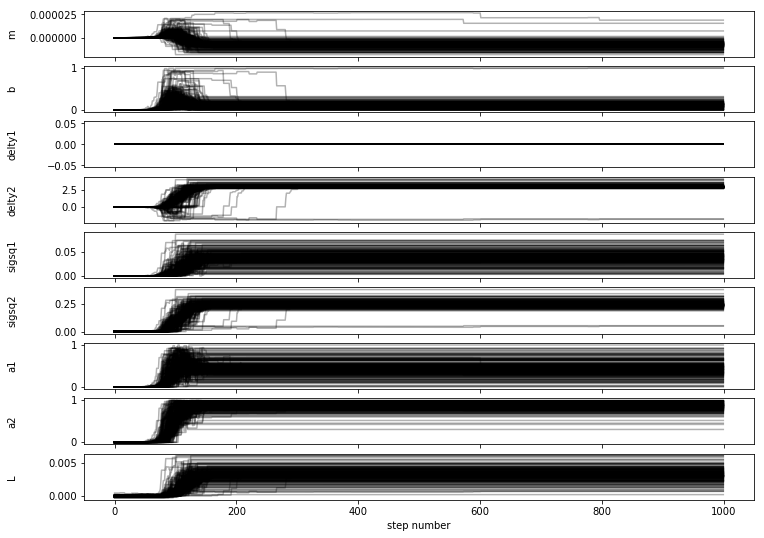

In [160]:
plt.figure(1)
fig, axes = plt.subplots(ndim, figsize=(12, 9), sharex=True)
samples = sampler.chain
labels = ["m", "b", "delty1", "delty2", "sigsq1", "sigsq2", "a1", "a2", "L"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i].T, "k", alpha=0.3)
#     ax.set_xlim(0, len(samples))
    #(nwalkers, nsteps, dim)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
fig.savefig("200walkers_smallinit_a2.0_1000steps_nongauss_noscatter_matrixeq22_L*2.png")
plt.show()

In [161]:
flat_samples = sampler.chain[:, 200:, :].reshape((-1, ndim))

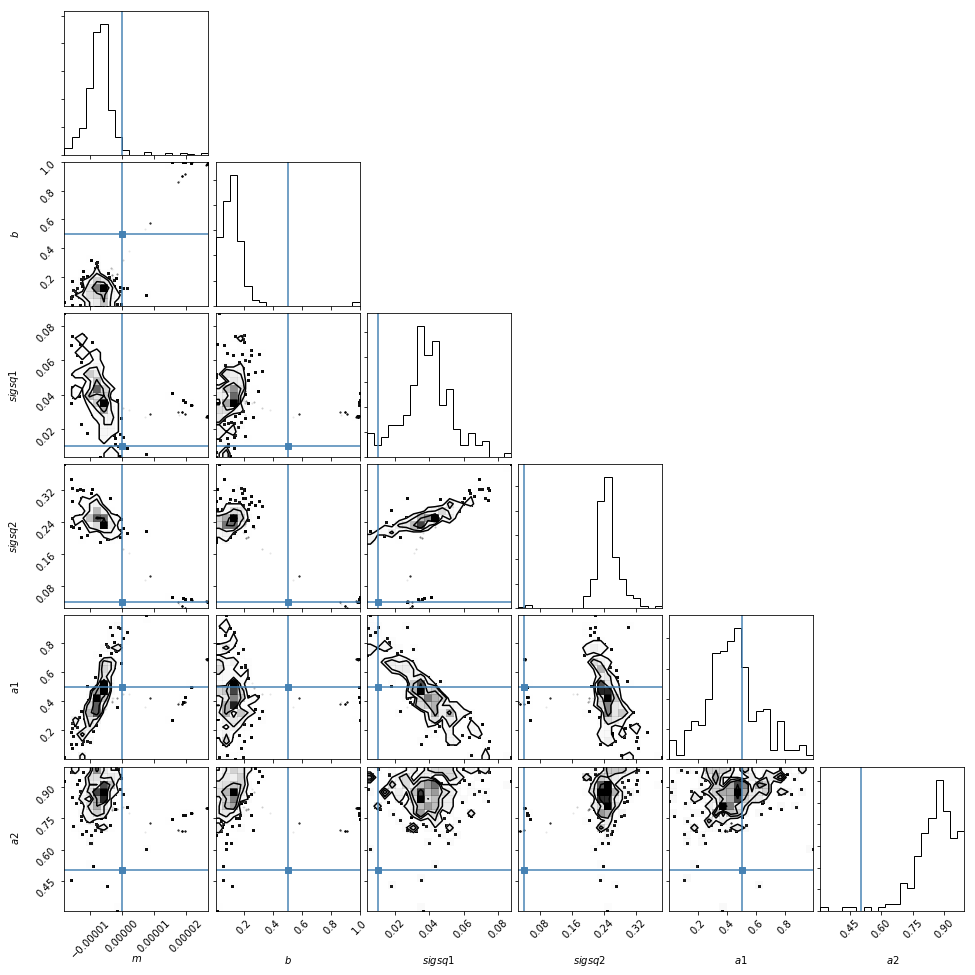

In [162]:
fig = corner.corner(flat_samples[:,[0,1,4,5,6,7]], labels=["$m$", "$b$", "$sigsq1$", "$sigsq2$", "$a1$", "$a2$"],
                      truths=[m_true, b_true, sigsq1_true, sigsq2_true, a1_true, a2_true])
fig.savefig("200walkers_smallinit_a2.0_1000steps_nongauss_noscatter_corner_matrixeq22_L*2.png")

In [163]:
from IPython.display import display, Math
results = []

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    results.append(mcmc)
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

-7.13555775731e-06 0.114930047648


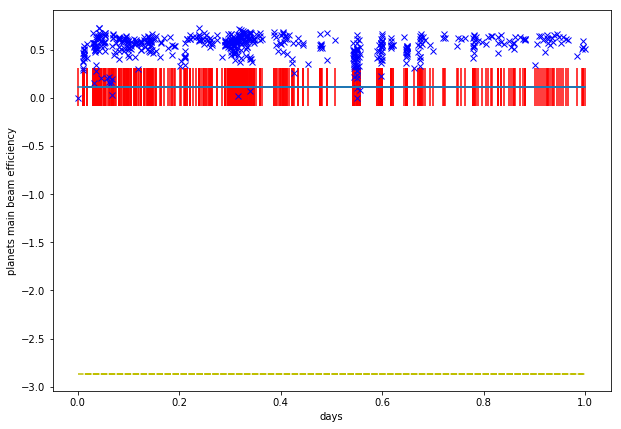

In [164]:
plt.figure(figsize=(10,7))
plt.plot(days, planets_etamb, 'bx')
m = results[0][1]
b = results[1][1]
print(m, b)
y = m*days/1000 + b
yerr = results[4][1]
bias = results[3][1]
plt.xlabel('days')
plt.ylabel('planets main beam efficiency')
plt.errorbar(days, y, yerr=np.sqrt(yerr), ecolor='red')
plt.plot(days, y - bias, '--', color='y')
plt.show()